# Check Spectrum calibration from Bouguer lines for BG40 date 2022/06/30, Spectractor mode PSF2DFFM


- author Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : October 13th 2022
- update : October 13th 2022



** Kernel anaconda3_auxtel**




# Import

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys,re

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline
import pickle

In [2]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [3]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [4]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
import pysynphot as S
S.refs.setref(area=1)
S.refs.getref()

{'graphtable': '/Users/sylvie/MacOSX/External/PySynPhotData/grp/redcat/trds/mtab/57g1733im_tmg.fits',
 'comptable': '/Users/sylvie/MacOSX/External/PySynPhotData/grp/redcat/trds/mtab/5as18041m_tmc.fits',
 'thermtable': '/Users/sylvie/MacOSX/External/PySynPhotData/grp/redcat/trds/mtab/3241637sm_tmt.fits',
 'area': 1,
 'waveset': 'Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True'}

In [5]:
import time
from datetime import datetime,date
from astropy.time import Time
import dateutil.parser
import pytz

import argparse

import logging
import coloredlogs
import configparser


In [6]:
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy import fftpack

In [7]:
# import libradtran
sys.path.append('../../../simulation/atmsim/libradtran')
import libsimulateVisible

libradtranpath= /Users/sylvie/MacOSX/External/libRadtran2/


In [8]:
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1, ATMOSPHERIC_LINES

In [9]:
HALPHA = Line(656.3, atmospheric=False, label='$H\\alpha$', label_pos=[-0.01, 0.02], use_for_calibration=True)
HBETA = Line(486.3, atmospheric=False, label='$H\\beta$', label_pos=[0.001, 0.02], use_for_calibration=True)
HGAMMA = Line(434.0, atmospheric=False, label='$H\\gamma$', label_pos=[0.001, 0.02], use_for_calibration=True)
HDELTA = Line(410.2, atmospheric=False, label='$H\\delta$', label_pos=[0.001, 0.02], use_for_calibration=True)
HEPSILON = Line(397.0, atmospheric=False, label='$H\\epsilon$', label_pos=[0.001, 0.02], use_for_calibration=True)

HZETA = Line(388.9064, atmospheric=False, label='$H\\zeta$', label_pos=[0.001, 0.02], use_for_calibration=False)
HETA = Line(383.5397, atmospheric=False, label='$H\\eta$', label_pos=[0.001, 0.02], use_for_calibration=False)

HBETA2 = Line(486.3*2, atmospheric=False, label='$H\\beta$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HGAMMA2 = Line(434.0*2, atmospheric=False, label='$H\\gamma$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HDELTA2 = Line(410.2*2, atmospheric=False, label='$H\\delta$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HEPSILON2 = Line(397.0*2, atmospheric=False, label='$H\\epsilon$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HZETA2 = Line(388.9064*2, atmospheric=False, label='$H\\zeta$2', label_pos=[0.001, 0.02], use_for_calibration=False)
HETA2 = Line(383.5397*2, atmospheric=False, label='$H\\eta$2', label_pos=[0.001, 0.02], use_for_calibration=False)

O2_1 = Line(760.3, atmospheric=True, label='$O_2$',label_pos=[0.001, 0.02], use_for_calibration=True)  # libradtran paper fig.3
O2_2 = Line(763.1, atmospheric=True, label='$O_2$',label_pos=[0.001, 0.02], use_for_calibration=True)  # libradtran paper fig.3

O2B = Line(687.472, atmospheric=True, label=r'$O_2(B)$',  # 687.472 is a weighted average of the O2B line simulated by Libradtran
           label_pos=[0.001, 0.02], use_for_calibration=True)  # https://en.wikipedia.org/wiki/Fraunhofer_lines
O2Y = Line(898.765, atmospheric=True, label=r'$O_2(Y)$',
           label_pos=[0.001, 0.02])  # https://en.wikipedia.org/wiki/Fraunhofer_lines
O2Z = Line(822.696, atmospheric=True, label=r'$O_2(Z)$',
           label_pos=[0.001, 0.02])  # https://en.wikipedia.org/wiki/Fraunhofer_lines
# H2O = Line( 960,atmospheric=True,label='$H_2 O$',label_pos=[0.007,0.02],width_bounds=(1,50))  #
H2O_1 = Line(935, atmospheric=True, label=r'$H_2 O$', label_pos=[0.001, 0.02],  # MFL: don't these need different labels?
             width_bounds=[5, 30])  # libradtran paper fig.3, broad line
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.001, 0.02],  # MFL: don't these need different labels?
              width_bounds=[5, 30])  # libradtran paper fig.3, broad line
ATMOSPHERIC_LINES = [O2_1, O2_2, O2B, O2Y, O2Z, H2O_1]


H2O_1 = Line(935, atmospheric=True, label=r'$H_2 O$', label_pos=[0.001, 0.02],  # MFL: don't these need different labels?
             width_bounds=[5, 30])  # libradtran paper fig.3, broad line
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.007, 0.02],width_bounds=[5, 30])  # libradtran paper fig.3, broad line

my_calib_lines_etador = Lines([HALPHA,HBETA,HGAMMA,HDELTA,HEPSILON,HBETA2,HGAMMA2,HDELTA2,HEPSILON2,HZETA2,O2_1,O2_2],hydrogen_only=True,atmospheric_lines=True, redshift=0, emission_spectrum=False)
hydrogen_lines_order1 =  Lines([HALPHA,HBETA,HGAMMA,HDELTA,HEPSILON])
hydrogen_lines_order2 =  Lines([HBETA2,HGAMMA2,HDELTA2,HEPSILON2,HZETA2,HETA2])
oxygen_lines_order1 = Lines([O2_1,O2_2])

In [10]:
#ax.plot([x_O2_1,x_O2_1],[72,100],'b-',lw=3)
#ax.annotate(O2_1.label, xy=(x_O2_1, 80), color='b',fontsize=20,fontweight='bold')
    

# Functions

- filtering here

https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way

In [11]:
def smooth_data_convolve_my_average(arr, span):
    re = np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

    # The "my_average" part: shrinks the averaging window on the side that 
    # reaches beyond the data, keeps the other side the same size as given 
    # by "span"
    re[0] = np.average(arr[:span])
    for i in range(1, span + 1):
        re[i] = np.average(arr[:i + span])
        re[-i] = np.average(arr[-i - span:])
    return re

def smooth_data_np_average(arr, span):  # my original, naive approach
    return [np.average(arr[val - span:val + span + 1]) for val in range(len(arr))]

def smooth_data_np_convolve(arr, span):
    return np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

def smooth_data_np_cumsum_my_average(arr, span):
    cumsum_vec = np.cumsum(arr)
    moving_average = (cumsum_vec[2 * span:] - cumsum_vec[:-2 * span]) / (2 * span)

    # The "my_average" part again. Slightly different to before, because the
    # moving average from cumsum is shorter than the input and needs to be padded
    front, back = [np.average(arr[:span])], []
    for i in range(1, span):
        front.append(np.average(arr[:i + span]))
        back.insert(0, np.average(arr[-i - span:]))
    back.insert(0, np.average(arr[-2 * span:]))
    return np.concatenate((front, moving_average, back))

def smooth_data_lowess(arr, span):
    x = np.linspace(0, 1, len(arr))
    return sm.nonparametric.lowess(arr, x, frac=(5*span / len(arr)), return_sorted=False)

def smooth_data_kernel_regression(arr, span):
    # "span" smoothing parameter is ignored. If you know how to 
    # incorporate that with kernel regression, please comment below.
    kr = KernelReg(arr, np.linspace(0, 1, len(arr)), 'c')
    return kr.fit()[0]

def smooth_data_savgol_0(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 0)

def smooth_data_savgol_1(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 1)

def smooth_data_savgol_2(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 2)

def smooth_data_fft(arr, span):  # the scaling of "span" is open to suggestions
    w = fftpack.rfft(arr)
    spectrum = w ** 2
    cutoff_idx = spectrum < (spectrum.max() * (1 - np.exp(-span / 2000)))
    w[cutoff_idx] = 0
    return fftpack.irfft(w)

In [12]:
def atmpatt_Dataf_to_np(df):
    """
    
    atmpatt_Dataf_to_np : convert pandas dtaframe on abs pattern into numpy array
    
    """
    o2_cols = []
    for tabcol in df.columns:
        if 'o2_' in tabcol and 'no2_' not in tabcol:
            o2_cols.append(tabcol)
            
    no2_cols = []
    for tabcol in df.columns:
        if 'no2_' in tabcol:
            no2_cols.append(tabcol)
            
            
    h2o_cols = []
    for tabcol in df.columns:
        if 'h2o_' in tabcol:
            h2o_cols.append(tabcol)
            
            
    o3_cols = []
    for tabcol in df.columns:
        if 'o3_' in  tabcol:
            o3_cols.append(tabcol)
            
            
    data_wl = df["wl"].to_numpy()
    data_o2 = df[o2_cols].to_numpy()
    data_o3 = df[o3_cols].to_numpy()
    data_h2o = df[h2o_cols].to_numpy()
    data_no2 = df[no2_cols].to_numpy()
    
    
    return data_wl, data_o2, data_o3, data_h2o, data_no2
    
    

In [13]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return a.flat[idx],int(idx)

In [14]:
def GetSpectra(dict_spectra):
    """
    GetSpectra(dict_spectra)
    
    input:
      - dict_spectra : dictionnary of input spectra
      
      
      {'number': 238.0, 'object': 'mu. Col', 'dateobs': '2022-03-18T00:51:22.049', 'refhour': 0.0, 'airmass': 1.11557476948966, 'pressure': 743.45, 'temperature': 8.9, 
      'humidity': 48.0, 'targetx_pix': 312.7442668572934, 'targety_pix': 1738.0006619324693, 'rotangle': 0.1753951396614214, 'd2ccd': 181.0974436798836, 
      'all_lambdas': array([ 302.20970512,  302.91544585,  303.62117594, ..., 1108.67461764,
       1109.35162338, 1110.02859124]), 'all_fluxes': array([1.04110833e-13, 9.83856109e-14, 8.99209206e-14, ...,
       5.34113538e-13, 5.36905940e-13, 5.53127394e-13]), 'all_fluxes_err': array([3.51303583e-15, 3.10100695e-15, 2.58677333e-15, ...,
       3.34568263e-15, 4.01784054e-15, 4.54242555e-15]), 'all_lambdas_order2': array([ 302.24857475,  302.9543149 ,  303.66004442, ..., 1108.71192607,
       1109.38892974, 1110.06589555]), 'all_fluxes_order2': array([420.23653349, 386.95227531, 344.90384603, ...,  60.47440612,
        60.74615545,  62.53491353]), 'all_fluxes_err_order2': array([14.15542468, 12.17674916,  9.90751987, ...,  0.37846535,
        0.45415764,  0.51307916])}
      
    
    return
      - list of dataframes
    """
    
    #correction_area = 1.06/1.13
    correction_area = 1
    
    list_of_columns = ["number","object",'dateobs','refhour','airmass','pressure','temperature','humidity','filename','targetx_pix', 'targety_pix','rotangle', 'd2ccd']   

    all_df = []  # container for spectra
    
    df_info = pd.DataFrame(columns=list_of_columns)
    
    idx=0
    for key, value in dict_spectra.items():
        
        df_info.loc[idx] = [int(value["number"]),value["object"],value["dateobs"],value["refhour"],value["airmass"],value["pressure"],value["temperature"],value["humidity"],key,value['targetx_pix'],value['targety_pix'],value['rotangle'], value['d2ccd']]
         
        df = pd.DataFrame()
        df["all_lambdas"] = value["all_lambdas"]
        df["all_fluxes"] = value["all_fluxes"]/ correction_area 
        df["all_fluxes_err"] = value["all_fluxes_err"]
        
        if 'all_lambdas_order2' in value.keys():
            df["all_lambdas_order2"] = value["all_lambdas_order2"]
            df["all_fluxes_order2"] = value["all_fluxes_order2"]/ correction_area 
            df["all_fluxes_err_order2"] = value["all_fluxes_err_order2"]
            
        
        all_df.append(df)
        
        
        idx+=1
        
    return df_info , all_df

In [15]:
def GetSpectraFiltered(dict_spectra,list_of_bad_spectra):
    """
    GetSpectraFiltered(inputdir,inputfiles)
    
    input:
      - dict_spectra
      - ist_of_bad_spectra
    
    return
      - filtered infos, filtered spectra
    """
    
    # factor to correct fluxes (over estimated collection surface)
    #correction_area = 1.06/1.13
    correction_area = 1
    
    
    
    list_of_columns = ["number","object",'dateobs','refhour','airmass','pressure','temperature','humidity','filename','targetx_pix', 'targety_pix','rotangle', 'd2ccd']   
        

    all_df = []  # container for spectra
    
    df_info = pd.DataFrame(columns=list_of_columns)
    
    idx=0       # counter on input spectra
    idx_out = 0 # counter on save spectra
    for key, value in dict_spectra.items():
        
        
        if int(value["number"]) not in list_of_bad_spectra:
        
            
            df_info.loc[idx] = [int(value["number"]),value["object"],value["dateobs"],value["refhour"],value["airmass"],value["pressure"],value["temperature"],value["humidity"],key,value['targetx_pix'],value['targety_pix'],value['rotangle'], value['d2ccd']] 
        
            df = pd.DataFrame()
            df["all_lambdas"] = value["all_lambdas"]
            df["all_fluxes"] = value["all_fluxes"]/correction_area
            df["all_fluxes_err"] = value["all_fluxes_err"]
        
            if 'all_lambdas_order2' in value.keys():
                df["all_lambdas_order2"] = value["all_lambdas_order2"]
                df["all_fluxes_order2"] = value["all_fluxes_order2"]/correction_area
                df["all_fluxes_err_order2"] = value["all_fluxes_err_order2"]
               
            all_df.append(df)
            idx_out+=1  # increase count on saved spectra
            
        else:
            num = int(value["number"])
            msg = f"Remove spectrum {idx} for exposure {num}"
            print(msg)
            
        idx+=1
            

        
    return df_info,all_df

In [16]:
def FindPairOfExposures(df):
    """
    
    Find pair of exposures at similar airmass, one before culmination, the other one after the exposure
    
    - input : pandas dataframe with infos
    - output : pandas dataframe with pairs
    
    """
    
    
 
    # the culmination  
    idx_zmin = df["airmass"].idxmin()
    
    # split this dataframe into 2
    
    # df before culmination
    df1 = df.iloc[0:idx_zmin]
    
    # df after culmination
    df2 = df.iloc[idx_zmin+1:-1]
    
    #print(df1)
    
    #print(df2)
    
    # loop on exposure before culmination
    #for irow in range(0,idx_zmin):
        # print(irow,df1.iloc[irow][["number","airmass"]])
        
    dist = np.abs(df1["airmass"][np.newaxis, :] - df2["airmass"][:, np.newaxis])
    #print(dist)
    closest_idx = np.argmin(dist, axis=0)
    closest_id = df2.iloc[closest_idx]["number"].to_numpy()
    df_output = pd.DataFrame({"idx1": np.arange(0,idx_zmin), 
                              "idx2": closest_idx+idx_zmin+1,
                              "num1":df1["number"],
                              "num2":closest_id,
                              "z1":df1["airmass"].values,
                              "z2":df2.iloc[closest_idx]["airmass"].to_numpy()})

    df_output["zdiff"] =  df_output["z2"]-df_output["z1"]
    df_output["dtime"] = df2.iloc[closest_idx]["refhour"].to_numpy()- df1["refhour"] 
    return df_output
    

# Constants

# Initialisation

In [17]:
# start with logs
#-----------------
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)

handle = __name__

logger = logging.getLogger(handle)
# logging.getLogger().setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

# If you don't want to see log messages from libraries, you can pass a
# specific logger object to the install() function. In this case only log
# messages originating from that logger will show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)
coloredlogs.install(fmt='%(asctime)s,%(msecs)03d %(hostname)s %(name)s[%(process)d] %(levelname)s %(message)s')

In [18]:
# set time
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")

# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)

# timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
msg="LA time:"+  datetime_LA.strftime("%H:%M:%S")
logger.info(msg)

tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
msg="NY time:"+ datetime_NY.strftime("%H:%M:%S")
logger.info(msg)

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
msg="London time:"+ datetime_London.strftime("%H:%M:%S")
logger.info(msg)

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
msg="Paris time:"+ datetime_Paris.strftime("%H:%M:%S")
logger.info(msg)

msg="************************ START *********************"
logger.info(msg)


2022-10-13 12:07:31,141 imacdagoret.lal.in2p3.fr __main__[80106] INFO LA time:03:07:31
2022-10-13 12:07:31,142 imacdagoret.lal.in2p3.fr __main__[80106] INFO NY time:06:07:31
2022-10-13 12:07:31,143 imacdagoret.lal.in2p3.fr __main__[80106] INFO London time:11:07:31
2022-10-13 12:07:31,144 imacdagoret.lal.in2p3.fr __main__[80106] INFO Paris time:12:07:31
2022-10-13 12:07:31,145 imacdagoret.lal.in2p3.fr __main__[80106] INFO ************************ START *********************


In [19]:
# arguments
#----------

parser = argparse.ArgumentParser()
parser.add_argument("--config",action="store", dest="configfile",help=f" run generate -config configfilename, with by ex configfilename = default.ini")
#results_args = parser.parse_args()

results_args=""


# Configuration

In [20]:
# config file
# --------------
#configfile = "config/default.ini"
configfile = "config/confprog_run-auxtel-holo-20220630-configPSF2DFFM_BG40.ini"
#config_filename = results_args.configfile
config_filename = configfile
msg = f"Configuration file : {config_filename}"
logger.info(msg)


2022-10-13 12:07:31,155 imacdagoret.lal.in2p3.fr __main__[80106] INFO Configuration file : config/confprog_run-auxtel-holo-20220630-configPSF2DFFM_BG40.ini


In [21]:
# 1) CONFIGURATION
#------------------
logger.info('1) Configuration')

config = configparser.ConfigParser()

if os.path.exists(config_filename):
    config.read(config_filename)
else:
    msg = f"config file {config_filename} does not exist !"
    logger.error(msg)

2022-10-13 12:07:31,160 imacdagoret.lal.in2p3.fr __main__[80106] INFO 1) Configuration


In [22]:
config_section = config.sections()

In [23]:
if len(config_section) == 0:
    msg = f"empty config file {config_filename} !"
    logger.error(msg)

In [24]:
if 'GENERAL' in config_section:

    FLAG_DEBUG = bool(int(config['GENERAL']['FLAG_DEBUG']))
    FLAG_VERBOSE = bool(int(config['GENERAL']['FLAG_VERBOSE']))
    FLAG_PLOT   = bool(int(config['GENERAL']['FLAG_PLOT']))
    FLAG_PRINT  = bool(int(config['GENERAL']['FLAG_PRINT']))
    
    SITE          = config['GENERAL']['SITE']
    DATE          = config['GENERAL']['DATE']
    
    inputdir    = config['GENERAL']['inputdir']
    inputfile   = config['GENERAL']['inputfile']
    filterdisperser =  config['GENERAL']['filterdisperser']
    
    
    target      = config['GENERAL']['object']
    sedfilename = config['GENERAL']['sedfilename']
    
    filename_auxtelthroughput = config['GENERAL']['filename_auxtelthroughput']
    filename_bluefilter        = config['GENERAL']['filename_bluefilter']
    
    spectractormode = config['GENERAL']['spectractormode']
    
   
    normalisationfactor = float(config['GENERAL']['normalisationfactor'])
    WLMINSEL      = float(config['GENERAL']['WLMINSEL'])
    WLMAXSEL      = float(config['GENERAL']['WLMAXSEL'])
    
    
    MAGLIMMIN     = float(config['GENERAL']['MAGLIMMIN'])
    MAGLIMMAX     = float(config['GENERAL']['MAGLIMMAX'])
    FLUXLIMMIN    = float(config['GENERAL']['FLUXLIMMIN'])
    FLUXLIMMAX    = float(config['GENERAL']['FLUXLIMMAX'])    
    
    NPOINTSVIEW       =    int(config['GENERAL']['NPOINTSVIEW']) 
    NPOINTSSAVE       =    int(config['GENERAL']['NPOINTSSAVE']) 
    inputfile_linearfit =  config['GENERAL']['outputfile_linearfit']
    inputfile_gp        =  config['GENERAL']['outputfile_gp']
    
    BADEXPOS = config['GENERAL']['BADEXPOS']
    

else:
    msg = f"Configuration file : empty section GENERAL in config file {config_filename} !"   
    logger.error(msg)

In [25]:
msg=f" Object observed {target} at {SITE} ({DATE})"
logger.info(msg)

2022-10-13 12:07:31,207 imacdagoret.lal.in2p3.fr __main__[80106] INFO  Object observed HD142331 at AUXTEL/Rubin Obs (2022-06-30)


In [26]:
input_file_split=inputfile.split(".")    
basefilename=input_file_split[0]
extendfilename=input_file_split[1]

In [27]:
list_of_badnums1 = [int(nn)  for nn in BADEXPOS.split()]
list_of_badnums1

[78, 123, 160, 320, 509, 538, 563, 564, 592]

In [28]:
WL= np.arange(WLMINSEL,WLMAXSEL)

# input files

## Get Calspec SED

- Notice we use a relative normalisation factor

In [29]:
s0=S.FileSpectrum(os.path.join(path_sed_calspec,sedfilename))

Warning, 62 of 6262 bins contained negative fluxes; they have been set to zero.


In [30]:
sed_w=s0.wave/10
sed_f=s0.flux*10*normalisationfactor
sed_idx=np.where(np.logical_and(sed_w>350,sed_w<1100))[0]
sed_w=sed_w[sed_idx]
sed_f=sed_f[sed_idx]

In [31]:
# interpolation function
f_sed = interpolate.interp1d(sed_w,sed_f,bounds_error=False,fill_value="extrapolate")

In [32]:
targetname = s0.fheader['TARGETID']

In [33]:
sed_m=-2.5*np.log10(sed_f)

Text(0, 0.5, 'mag')

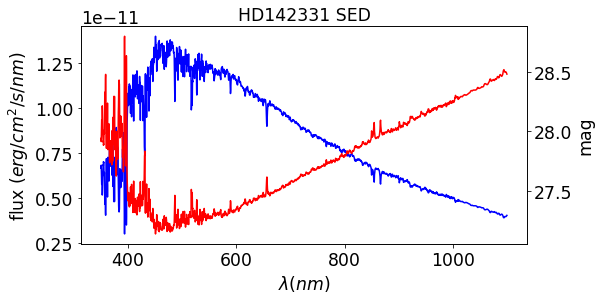

In [34]:
fig=plt.figure(figsize=(8,4))
ax=fig.add_subplot(1,1,1)
ax.plot(sed_w,sed_f,'b')
ax.set_xlabel("$\\lambda (nm)$")
ax.set_ylabel("flux $(erg/cm^2/s/nm)$")
ax.set_title(targetname + " SED")
ax2=ax.twinx()
ax2.plot(sed_w,sed_m,'r-')
ax2.set_ylabel("mag")

# Simulate the atmosphere

In [35]:
am       = 1.2
pressure = 0. # use default value
pwv      = 4.0
aer      = 0.1
ozone    = 300.
cloudext = 0

In [36]:
path,thefile=libsimulateVisible.ProcessSimulation(am,pwv,ozone,pressure,prof_str='us',proc_str='sa',cloudext=cloudext)
data = np.loadtxt(os.path.join(path,thefile))
wlsim = data[:,0]
atmsim = data[:,1] 

In [37]:
NBINSIM=len(wlsim)
NBINSIM

951

Text(0.5, 1.0, 'atmospheric transmission')

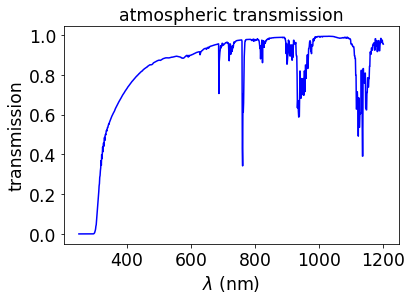

In [38]:
fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(111)
ax.plot(wlsim,atmsim,"b-")
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("transmission")
ax.set_title("atmospheric transmission")

In [39]:
f_atm = interpolate.interp1d(wlsim,atmsim,bounds_error=False,fill_value="extrapolate")

# Throughputs

## Auxtel throughput and  telescope throughput

In [40]:
array = np.loadtxt(filename_auxtelthroughput)
dft = pd.DataFrame(data=array,columns=["lambda","throughput"])

In [41]:
#dft = pd.read_excel(filename_auxtelthroughput,header=1,index_col=0)
dft.reset_index(inplace=True)
dft['index'] = dft.reset_index().index
dft.set_index('index')
dft.rename(columns={'lambda':'lambdas'},inplace = True)

Text(0.5, 1.0, 'auxtel throughput')

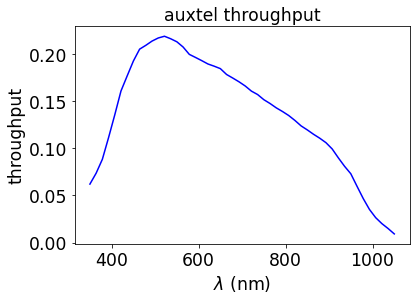

In [42]:
fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(111)
ax.plot(dft.lambdas,dft.throughput,"b-")
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("throughput")
ax.set_title("auxtel throughput")

In [43]:
# interpolation function
f_thr = interpolate.interp1d(dft.lambdas,dft.throughput,bounds_error=False,fill_value="extrapolate")

## Filter

In [44]:
arr =  np.loadtxt(filename_bluefilter)

(300.0, 700.0)

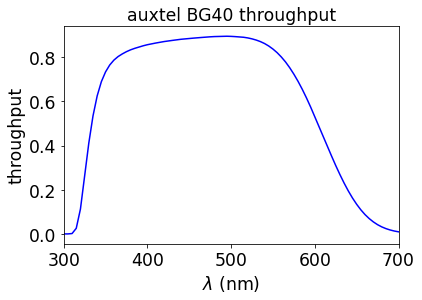

In [45]:
fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(111)
ax.plot(arr[:,0],arr[:,1],"b-")
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("throughput")
ax.set_title("auxtel BG40 throughput")
ax.set_xlim(300,WLMAXSEL)

In [46]:
f_filter_thr = interpolate.interp1d(arr[:,0],arr[:,1],bounds_error=False,fill_value="extrapolate")

## spectrum data

In [47]:
fullfilename=os.path.join(inputdir,inputfile)

In [48]:
with open(fullfilename, 'rb') as f:
    summary_content = pickle.load(f)

In [49]:
NBSPECTRA=len(summary_content)

In [50]:
msg=f" Number of selected files is {NBSPECTRA}"
logger.info(msg)

2022-10-13 12:07:39,527 imacdagoret.lal.in2p3.fr __main__[80106] INFO  Number of selected files is 31


In [51]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)

### Read all files

In [52]:
infos, all_spectra = GetSpectra(summary_content)

In [53]:
infos

,number,object,dateobs,refhour,airmass,pressure,temperature,humidity,filename,targetx_pix,targety_pix,rotangle,d2ccd
0,78,HD185975,2022-06-30T23:37:49.993,0.000000,2.023669,740.45,7.1,21.0,exposure_2022063000078_postisrccd_spectrum.fits,297.630988,1755.085787,0.240220,185.992642
1,79,HD185975,2022-06-30T23:38:33.068,0.011965,2.023198,740.45,7.1,21.0,exposure_2022063000079_postisrccd_spectrum.fits,305.622230,1752.623237,0.246925,179.281397
2,93,HD142331,2022-06-30T23:48:51.476,0.183745,1.268826,740.35,7.0,22.0,exposure_2022063000093_postisrccd_spectrum.fits,318.048416,1745.888769,0.247641,179.729947
3,94,HD142331,2022-06-30T23:49:34.392,0.195666,1.266461,740.35,7.0,22.0,exposure_2022063000094_postisrccd_spectrum.fits,319.263395,1745.877037,0.247028,179.781641
4,108,HD142331,2022-06-30T23:58:45.091,0.348638,1.237857,740.30,6.7,22.0,exposure_2022063000108_postisrccd_spectrum.fits,306.820786,1746.724749,0.252121,179.990008
5,123,HD142331,2022-07-01T00:08:36.213,0.512839,1.210461,740.30,6.7,22.0,exposure_2022063000123_postisrccd_spectrum.fits,309.914067,1762.884942,0.293194,168.723061
6,138,HD142331,2022-07-01T00:18:32.201,0.678391,1.186018,740.35,6.4,23.0,exposure_2022063000138_postisrccd_spectrum.fits,310.382069,1747.307966,0.252611,179.752889
7,160,HD185975,2022-07-01T00:35:27.889,0.960527,1.984954,740.25,6.2,23.0,exposure_2022063000160_postisrccd_spectrum.fits,313.944039,1757.483559,-0.280001,173.947893
8,219,HD142331,2022-07-01T01:21:46.382,1.732330,1.090862,740.20,5.5,25.0,exposure_2022063000219_postisrccd_spectrum.fits,319.305742,1733.302500,0.267885,183.560948
9,234,HD142331,2022-07-01T01:31:42.373,1.897883,1.083964,740.15,5.2,29.0,exposure_2022063000234_postisrccd_spectrum.fits,315.838229,1741.335465,0.252831,180.352310


In [54]:
N=len(infos)

In [55]:
NX=4
NY=N/NX

In [56]:
if NY != int(NY):
    NY= int(NY)+1
else:
    NY=int(NY)

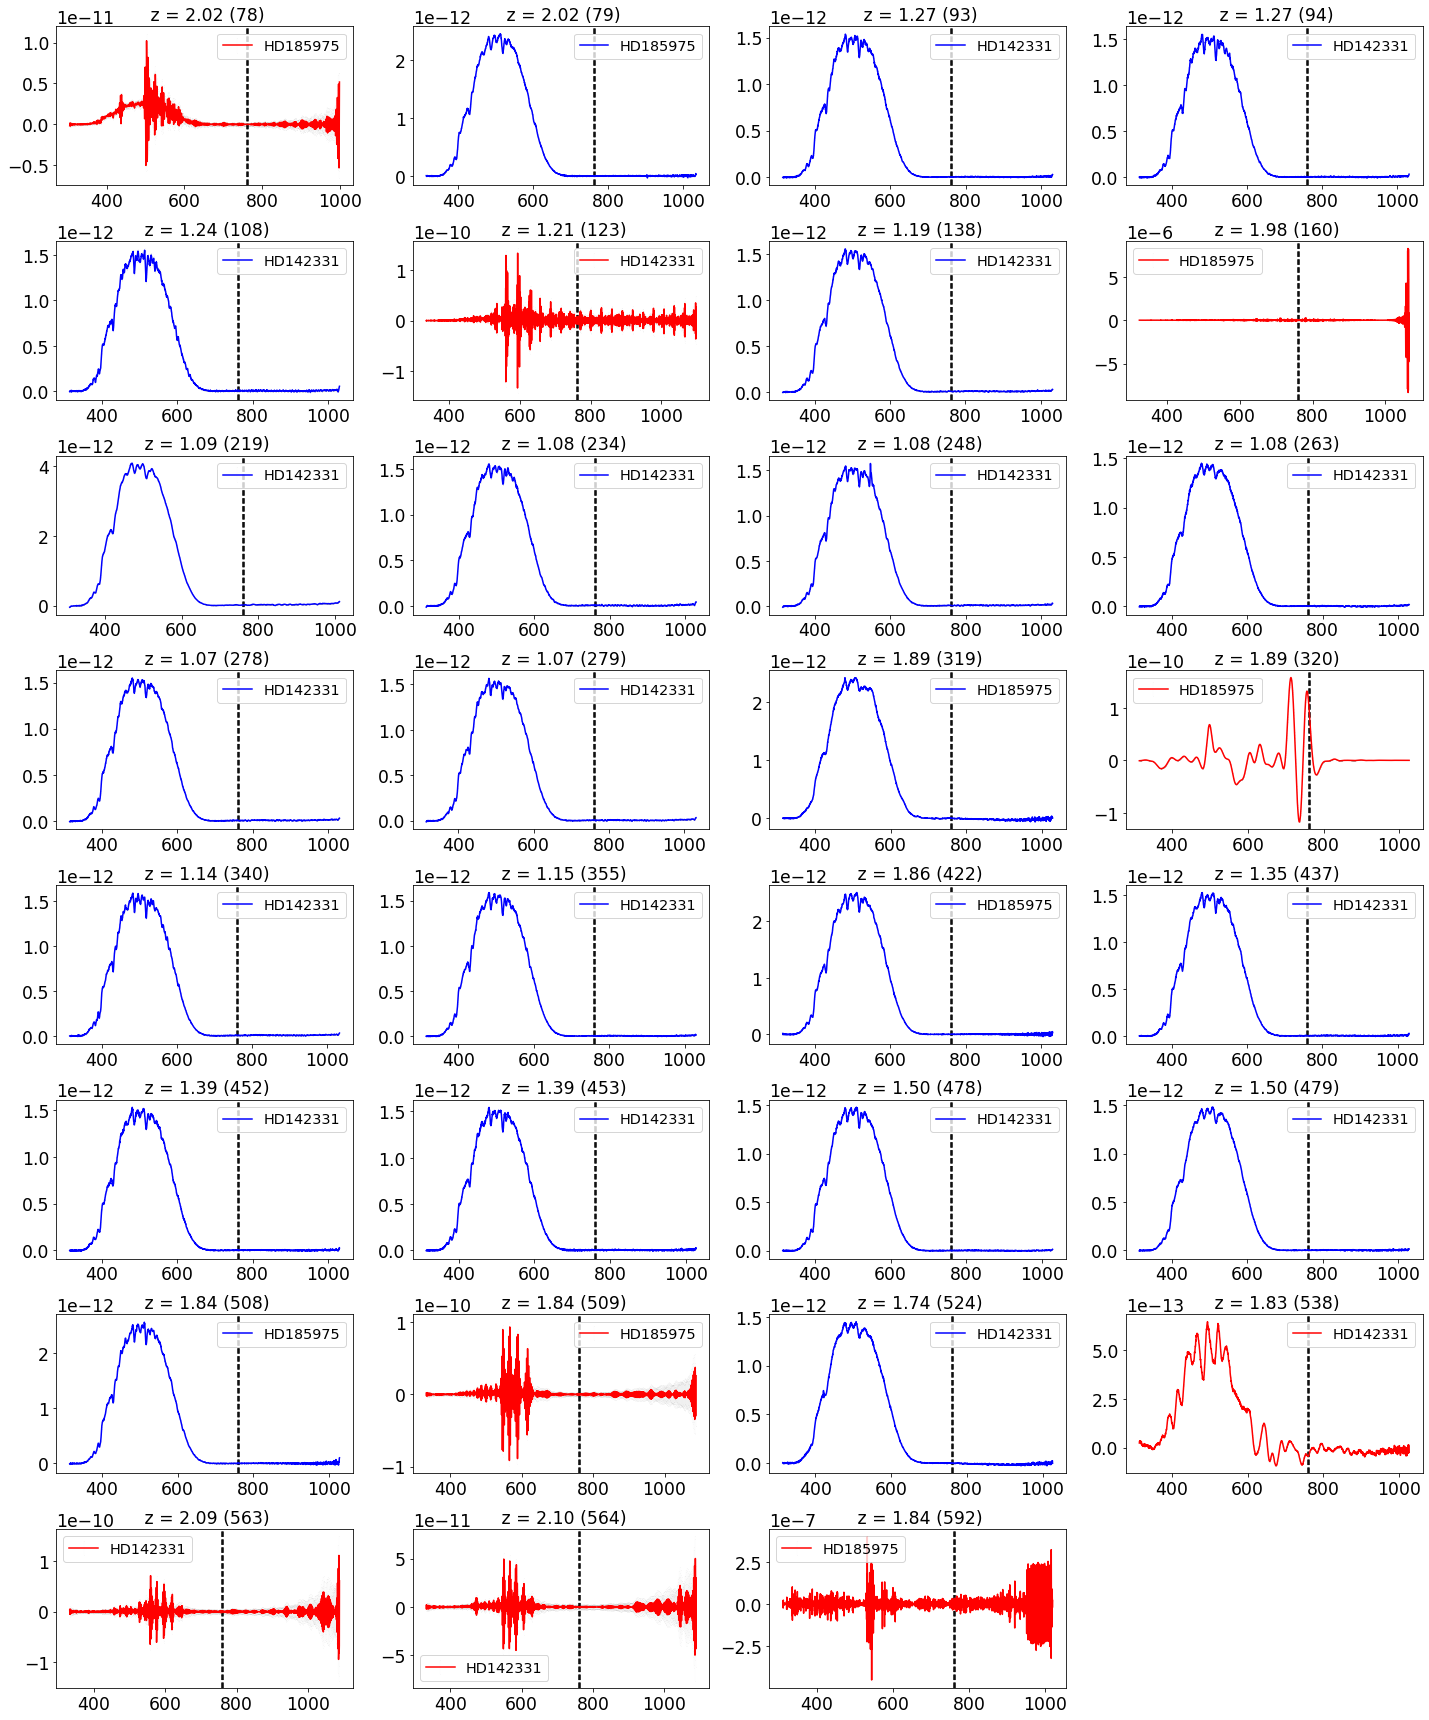

In [57]:
fig = plt.figure(figsize=(20,NY*3))

ny=0
nx=0

for idx in range(N):
    iy = idx//NX
    ix = (idx-iy*NX)
    
    ax=fig.add_subplot(NY,NX,idx+1)
    
    
    
    the_df=all_spectra[idx]
    
    airmassvalue = infos.iloc[idx]["airmass"]
    num = infos.iloc[idx]["number"]
    label_airmass = f" z = {airmassvalue:.2f} ({num})"
    the_target = infos.iloc[idx]["object"]
    
    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    if num in list_of_badnums1:
        thecolor="r"
    else:
        thecolor="b"
        
    # O2 line
    ax.axvline(O2_1.wavelength,linestyle="--",color="k")
    #ax.annotate(O2_1.label, xy=(O2_1.wavelength-5, FLUXLIMMAX/2), color='blue',fontsize=20,fontweight='bold')

    ax.axvline(O2_2.wavelength,linestyle="--",color="k")
    #ax.annotate(O2_2.label, xy=(O2_2.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')
    
    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes'],yerr=the_df["all_fluxes_err"], fmt = '-', color=thecolor,capsize = 0.01, ecolor="k", elinewidth = .01,label=the_target)
    ax.set_title(label_airmass)
    ax.legend()
    
plt.tight_layout()

# Remove bad Spectra

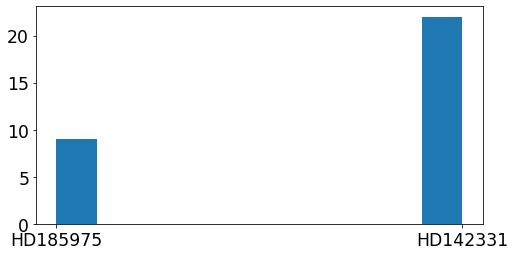

In [58]:
fig = plt.figure(figsize=(8,4))
ax=fig.add_subplot(1,1,1)
ax.hist(infos.object);

Text(0.5, 0.98, 'Variables to apply selection')

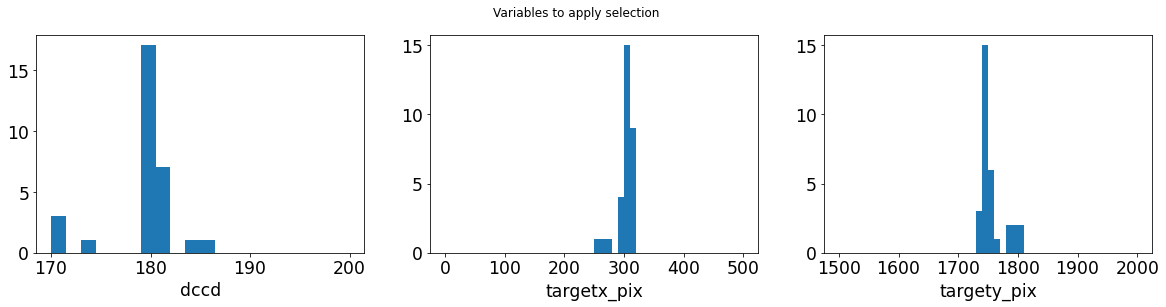

In [59]:
fig = plt.figure(figsize=(20,4))
ax=fig.add_subplot(1,3,1)
ax.hist(infos.d2ccd,bins=20,range=(170,200));
ax.set_xlabel("dccd")
ax=fig.add_subplot(1,3,2)
ax.hist(infos.targetx_pix,bins=50,range=(0,500));
ax.set_xlabel("targetx_pix")
ax=fig.add_subplot(1,3,3)
ax.hist(infos.targety_pix,bins=50,range=(1500,2000));
ax.set_xlabel("targety_pix")
plt.suptitle("Variables to apply selection")

## Define selection cut

In [60]:
selection_cut = ((infos.d2ccd > 178) & (infos.d2ccd < 182)) & (infos.object == target)
bad_cut = ~selection_cut

In [61]:
list_of_badnums2 = infos[bad_cut]["number"].values
list_of_badnums2 

array([78, 79, 123, 160, 219, 319, 320, 422, 508, 509, 563, 564, 592],
      dtype=object)

# Union of badnums

In [62]:
list_of_badnums = np.union1d(list_of_badnums1,list_of_badnums2)
list_of_badnums=np.unique(list_of_badnums)

# Filtered spectra : remove bad spectra

In [63]:
list_of_badnums

array([78, 79, 123, 160, 219, 319, 320, 422, 508, 509, 538, 563, 564, 592],
      dtype=object)

In [64]:
infos, all_spectra = GetSpectraFiltered(summary_content,list_of_bad_spectra=list_of_badnums)

Remove spectrum 0 for exposure 78
Remove spectrum 1 for exposure 79
Remove spectrum 5 for exposure 123
Remove spectrum 7 for exposure 160
Remove spectrum 8 for exposure 219
Remove spectrum 14 for exposure 319
Remove spectrum 15 for exposure 320
Remove spectrum 18 for exposure 422
Remove spectrum 24 for exposure 508
Remove spectrum 25 for exposure 509
Remove spectrum 27 for exposure 538
Remove spectrum 28 for exposure 563
Remove spectrum 29 for exposure 564
Remove spectrum 30 for exposure 592


In [65]:
print("Number of spectra : ",len(all_spectra))

Number of spectra :  17


In [66]:
infos.reset_index(drop=True, inplace=True)

In [67]:
infos

,number,object,dateobs,refhour,airmass,pressure,temperature,humidity,filename,targetx_pix,targety_pix,rotangle,d2ccd
0,93,HD142331,2022-06-30T23:48:51.476,0.183745,1.268826,740.35,7.0,22.0,exposure_2022063000093_postisrccd_spectrum.fits,318.048416,1745.888769,0.247641,179.729947
1,94,HD142331,2022-06-30T23:49:34.392,0.195666,1.266461,740.35,7.0,22.0,exposure_2022063000094_postisrccd_spectrum.fits,319.263395,1745.877037,0.247028,179.781641
2,108,HD142331,2022-06-30T23:58:45.091,0.348638,1.237857,740.30,6.7,22.0,exposure_2022063000108_postisrccd_spectrum.fits,306.820786,1746.724749,0.252121,179.990008
3,138,HD142331,2022-07-01T00:18:32.201,0.678391,1.186018,740.35,6.4,23.0,exposure_2022063000138_postisrccd_spectrum.fits,310.382069,1747.307966,0.252611,179.752889
4,234,HD142331,2022-07-01T01:31:42.373,1.897883,1.083964,740.15,5.2,29.0,exposure_2022063000234_postisrccd_spectrum.fits,315.838229,1741.335465,0.252831,180.352310
5,248,HD142331,2022-07-01T01:40:58.304,2.052309,1.079273,740.15,5.1,26.0,exposure_2022063000248_postisrccd_spectrum.fits,302.611272,1744.442203,0.261100,180.403682
6,263,HD142331,2022-07-01T01:50:57.537,2.218762,1.076058,740.05,5.1,27.0,exposure_2022063000263_postisrccd_spectrum.fits,304.823184,1748.929403,0.249730,180.327468
7,278,HD142331,2022-07-01T02:00:55.370,2.384827,1.074731,740.05,4.9,26.0,exposure_2022063000278_postisrccd_spectrum.fits,308.954111,1740.641148,0.260255,180.244441
8,279,HD142331,2022-07-01T02:01:38.277,2.396746,1.074705,740.05,4.9,26.0,exposure_2022063000279_postisrccd_spectrum.fits,308.846027,1739.605508,0.256467,180.040314
9,340,HD142331,2022-07-01T03:21:52.861,3.734130,1.135884,740.25,4.7,21.0,exposure_2022063000340_postisrccd_spectrum.fits,302.886211,1737.996031,0.256878,179.553866


# Plot Spectra

In [68]:
NBSPECTRA=len(all_spectra)

In [69]:
assert NBSPECTRA == len(infos)

In [70]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)

In [71]:
msg=f" Number of good spectra is {NBSPECTRA}"
logger.info(msg)

2022-10-13 12:07:45,197 imacdagoret.lal.in2p3.fr __main__[80106] INFO  Number of good spectra is 17


### load absorption pattern

In [72]:
df = pd.read_csv("data/absorption_pattern.csv")
wlpt,o2,o3,h2o,no2 = atmpatt_Dataf_to_np(df)

In [73]:
def plotlines(ax,ypos):
    ax.axvline(HBETA.wavelength,color='orange')
    ax.annotate(HBETA.label, xy=(HBETA.wavelength, ypos), color='green',fontsize=20,fontweight='bold')

    ax.axvline(HGAMMA.wavelength,color='orange')
    ax.annotate(HGAMMA.label, xy=(HGAMMA.wavelength, ypos), color='green',fontsize=20,fontweight='bold')
    
    ax.axvline(HDELTA.wavelength,color='orange')
    ax.annotate(HDELTA.label, xy=(HDELTA.wavelength, ypos), color='green',fontsize=20,fontweight='bold')

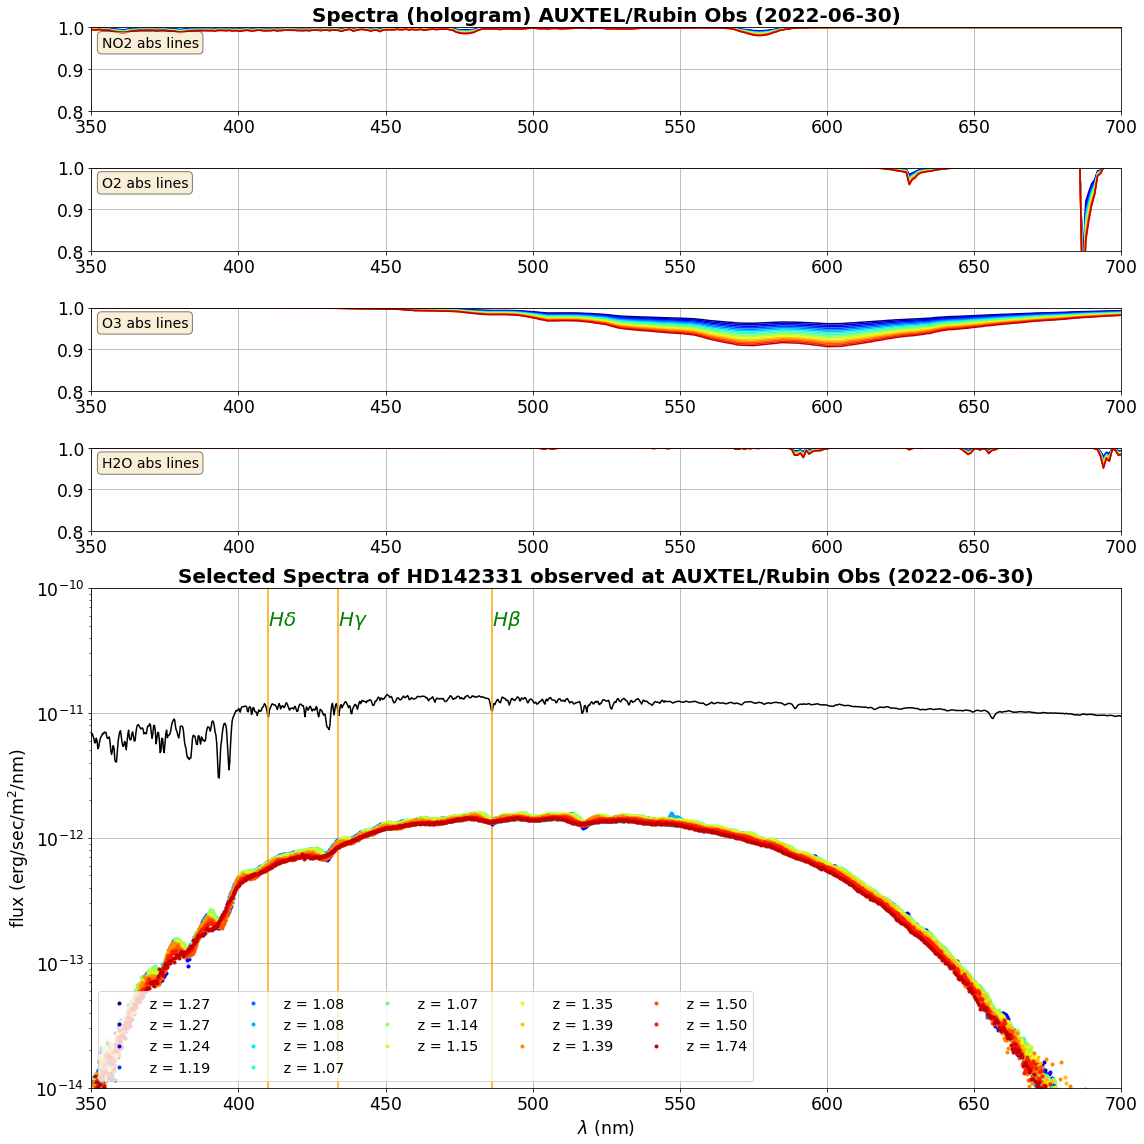

In [74]:
figsize=(16,16)

NOBS = o2.shape[1]
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

fig=plt.figure(figsize=figsize)
title =f"Spectra (hologram) {SITE} ({DATE})"


gs = gridspec.GridSpec(5, 1,height_ratios=[0.5,0.5,0.5,0.5,3] ,figure=fig)

# NO2    
ax=fig.add_subplot(gs[0,0])
for index in np.arange(NOBS):   
    ax.plot(wlpt,no2[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.grid()
textstr = "NO2 abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_title(title,fontsize=20,fontweight='bold')
main_ax = ax



# O2    
ax=fig.add_subplot(gs[1,0], sharex=main_ax)
for index in np.arange(NOBS):   
    ax.plot(wlpt,o2[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.grid()
textstr = "O2 abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
#ax.set_title(title)


# Ozone
ax=fig.add_subplot(gs[2,0], sharex=main_ax)
for index in np.arange(NOBS):   
    ax.plot(wlpt,o3[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.grid()
textstr = "O3 abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


# H2O
ax=fig.add_subplot(gs[3,0], sharex=main_ax)

for index in np.arange(NOBS):   
    ax.plot(wlpt,h2o[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.grid()
textstr = "H2O abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


# spectrum
ax=fig.add_subplot(gs[4,0], sharex=main_ax)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)
for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    
    airmassvalue = infos.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.2f}"

    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes'],yerr=the_df["all_fluxes_err"], fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Selected Spectra of {target} observed at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
ax.plot(sed_w,sed_f,'k-')
#ax.set_xlim(WLMINSEL,WLMAXSEL)
#ax.set_ylim(1e-14,1e-10)
ax.set_ylim(FLUXLIMMIN,FLUXLIMMAX)
ax.set_yscale("log")
ax.legend(loc="lower left",ncol=5)

# draw abs lines
plotlines(ax,ypos=FLUXLIMMAX/2)




plt.tight_layout()


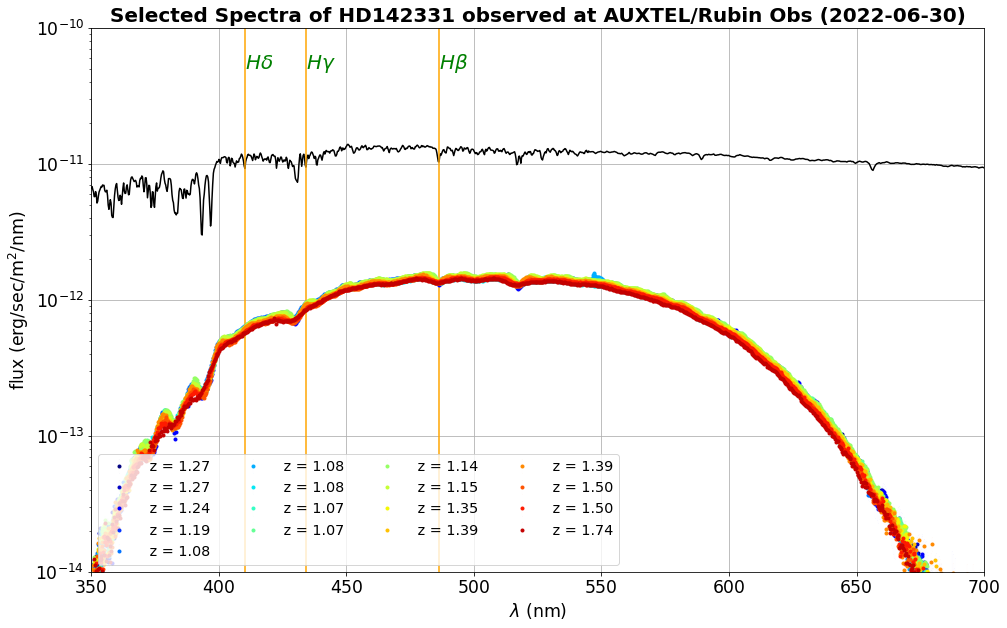

In [75]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    
    airmassvalue = infos.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.2f}"

    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes'],yerr=the_df["all_fluxes_err"], fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Selected Spectra of {target} observed at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
ax.plot(sed_w,sed_f,'k-')
ax.set_xlim( WLMINSEL  , WLMAXSEL  )
ax.set_ylim(FLUXLIMMIN,FLUXLIMMAX)
ax.set_yscale("log")
ax.legend(loc="lower left",ncol=4)
#ax.legend(bbox_to_anchor=(1.02, 0.5))

# draw abs lines
plotlines(ax,ypos=FLUXLIMMAX/2)


/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sylvie/opt/anaconda3/lib/python3.9/site-pac

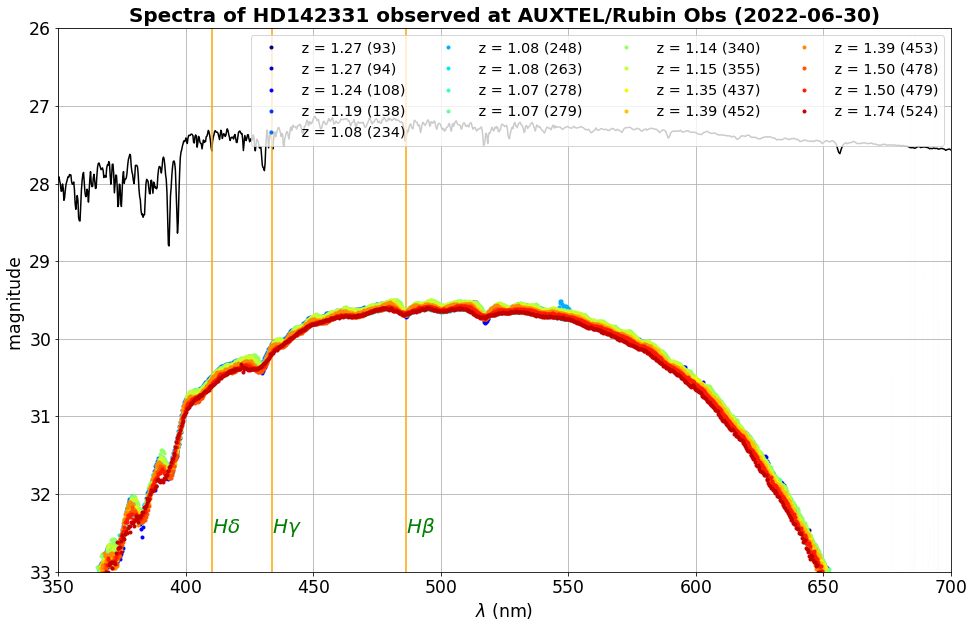

In [76]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=the_df=all_spectra[ifile]

    airmassvalue = infos.iloc[ifile]["airmass"]
    num = infos.iloc[ifile]["number"]
    label_airmass = f" z = {airmassvalue:.2f} ({num})"
    
    #ax.plot(the_df.wavelength,the_df.mag,color=all_colors[ifile])
    mag = -2.5*np.log10(the_df["all_fluxes"])
    errmag = 2.5/np.log(10)*the_df["all_fluxes_err"]/(the_df["all_fluxes"])
    ax.errorbar(the_df["all_lambdas"],mag,yerr=errmag, fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("magnitude ")
title=f"Spectra of {target} observed at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
ax.plot(sed_w,sed_m,'k-')
ax.set_xlim( WLMINSEL  , WLMAXSEL  )
ax.set_ylim(MAGLIMMIN,MAGLIMMAX)
ax.invert_yaxis()
ax.legend(loc="upper right",ncol=4)
#ax.legend(bbox_to_anchor=(1.02, 0))

# draw abs lines
plotlines(ax,ypos=MAGLIMMAX-0.5)


/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sylvie/opt/anaconda3/lib/python3.9/site-pac

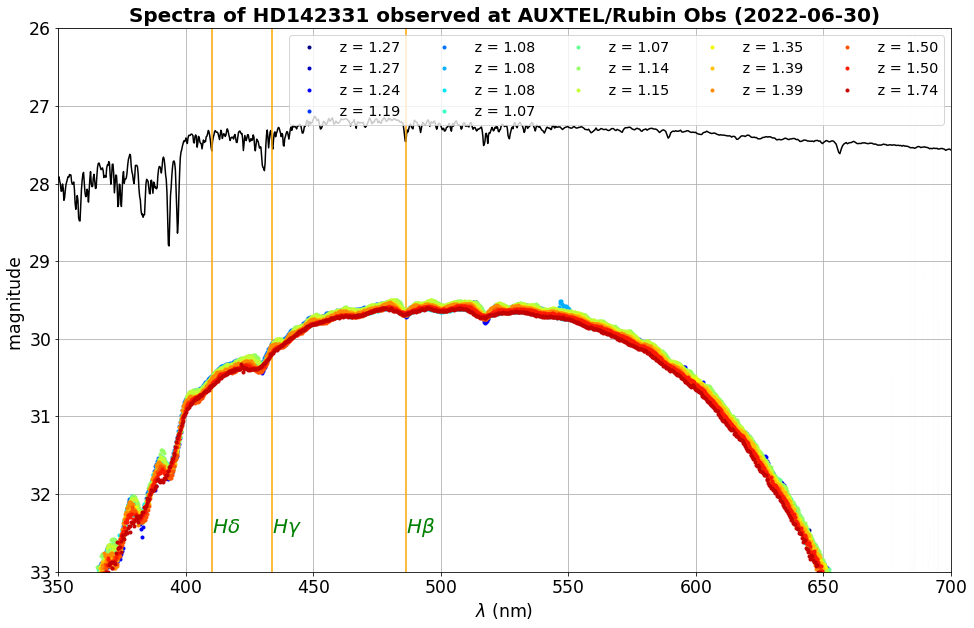

In [77]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=the_df=all_spectra[ifile]

    airmassvalue = infos.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.2f}"
    
    #ax.plot(the_df.wavelength,the_df.mag,color=all_colors[ifile])
    mag = -2.5*np.log10(the_df["all_fluxes"])
    errmag = 2.5/np.log(10)*the_df["all_fluxes_err"]/(the_df["all_fluxes"])
    ax.errorbar(the_df["all_lambdas"],mag,yerr=errmag, fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("magnitude ")
title=f"Spectra of {target} observed at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
ax.plot(sed_w,sed_m,'k-')
ax.set_xlim( WLMINSEL  , WLMAXSEL  )
ax.set_ylim(MAGLIMMIN,MAGLIMMAX)
ax.invert_yaxis()
ax.legend(loc="upper right",ncol=5)
#ax.legend(bbox_to_anchor=(1.02, 0))
# draw abs lines
plotlines(ax,ypos=MAGLIMMAX-0.5)

# Multiply SED by all throughput

In [78]:
correction_area = 1.06/1.13

In [79]:
sed_predicted_f = f_sed(WL) * f_thr(WL) * f_atm(WL) * f_filter_thr(WL)
sed_predicted_m = -2.5*np.log10(sed_predicted_f) 

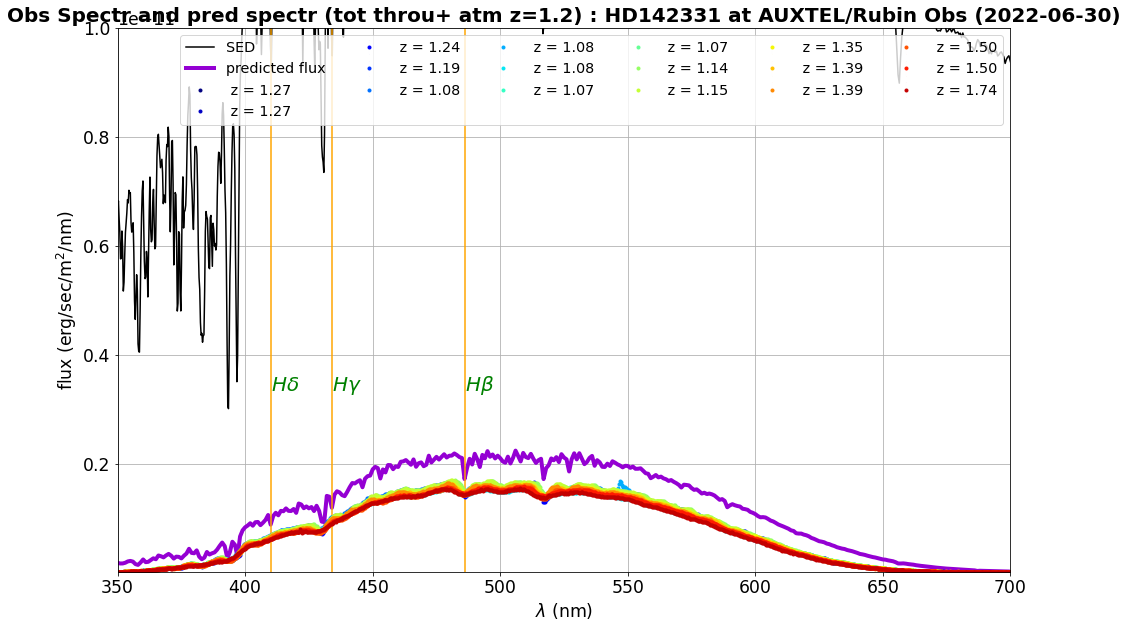

In [80]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    
    airmassvalue = infos.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.2f}"

    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes']/correction_area,yerr=the_df["all_fluxes_err"], fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Obs Spectr and pred spectr (tot throu+ atm z=1.2) : {target} at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
ax.plot(sed_w,sed_f,'k-',label="SED")
ax.plot(WL,sed_predicted_f,color='darkviolet',lw=4,label = "predicted flux")
ax.set_xlim( WLMINSEL  , WLMAXSEL  )
ax.set_ylim(FLUXLIMMIN,FLUXLIMMAX/10.)
#ax.set_yscale("log")
ax.legend(loc="upper right",ncol=6)


# draw abs lines
plotlines(ax,ypos=FLUXLIMMAX/30)



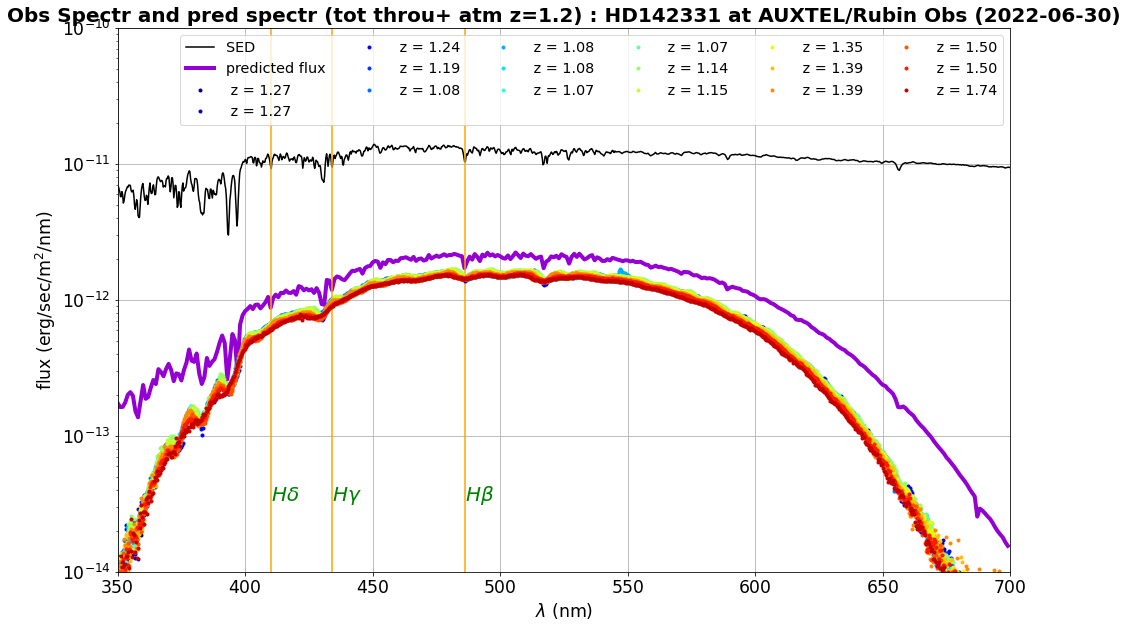

In [81]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    
    airmassvalue = infos.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.2f}"

    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes']/correction_area,yerr=the_df["all_fluxes_err"], fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Obs Spectr and pred spectr (tot throu+ atm z=1.2) : {target} at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
ax.plot(sed_w,sed_f,'k-',label="SED")
ax.plot(WL,sed_predicted_f,color='darkviolet',lw=4,label = "predicted flux")
ax.set_xlim( WLMINSEL  , WLMAXSEL  )
ax.set_ylim(FLUXLIMMIN,FLUXLIMMAX)
ax.set_yscale("log")
ax.legend(loc="upper right",ncol=6)

# draw abs lines
plotlines(ax,ypos=FLUXLIMMAX/3000)

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sylvie/opt/anaconda3/lib/python3.9/site-pac

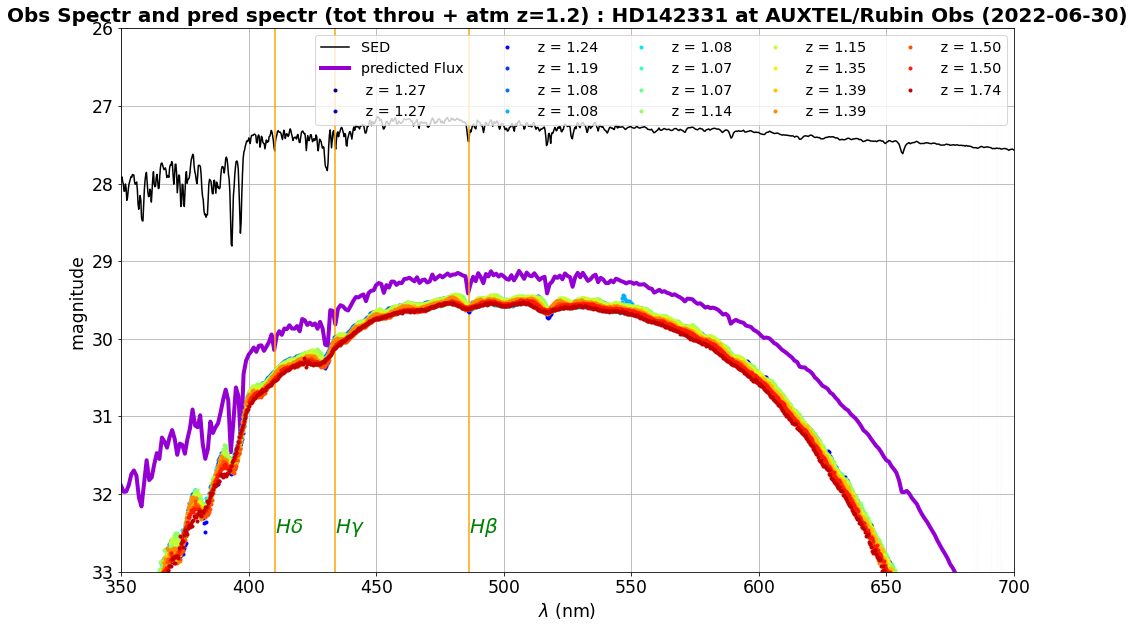

In [82]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=the_df=all_spectra[ifile]

    airmassvalue = infos.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.2f}"
    
    #ax.plot(the_df.wavelength,the_df.mag,color=all_colors[ifile])
    mag = -2.5*np.log10(the_df["all_fluxes"]/correction_area)
    errmag = 2.5/np.log(10)*the_df["all_fluxes_err"]/(the_df["all_fluxes"])
    ax.errorbar(the_df["all_lambdas"],mag,yerr=errmag, fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("magnitude ")
title=f"Obs Spectr and pred spectr (tot throu + atm z=1.2) : {target} at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
ax.plot(sed_w,sed_m,'k-',label = 'SED')
ax.plot(WL,sed_predicted_m,color='darkviolet',lw=4,label = "predicted Flux")

ax.set_ylim(MAGLIMMIN,MAGLIMMAX)
ax.set_xlim( WLMINSEL  , WLMAXSEL  )

ax.invert_yaxis()

ax.legend(loc="upper right",ncol=5)

# draw abs lines
plotlines(ax,ypos=MAGLIMMAX-0.5)

# Filtering a line

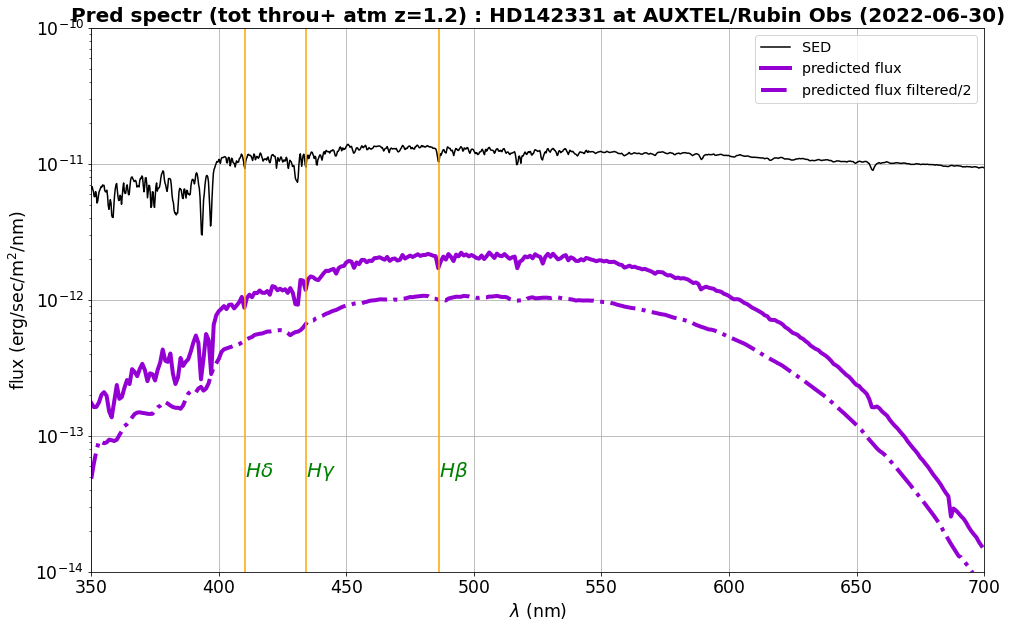

In [83]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Pred spectr (tot throu+ atm z=1.2) : {target} at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
ax.plot(sed_w,sed_f,'k-',label="SED")
ax.plot(WL,sed_predicted_f,color='darkviolet',lw=4,label = "predicted flux")
ax.set_xlim( WLMINSEL  , WLMAXSEL  )
ax.set_ylim(FLUXLIMMIN,FLUXLIMMAX)

# filtered flux
span = 3
sed_predicted_f_filtered = smooth_data_np_convolve(sed_predicted_f, span)
ax.plot(WL,sed_predicted_f_filtered/2,"-.",color='darkviolet',lw=4,label = "predicted flux filtered/2")


ax.set_yscale("log")
ax.legend(loc="upper right")


# draw abs lines
plotlines(ax,ypos=FLUXLIMMAX/2000)

# Ratio

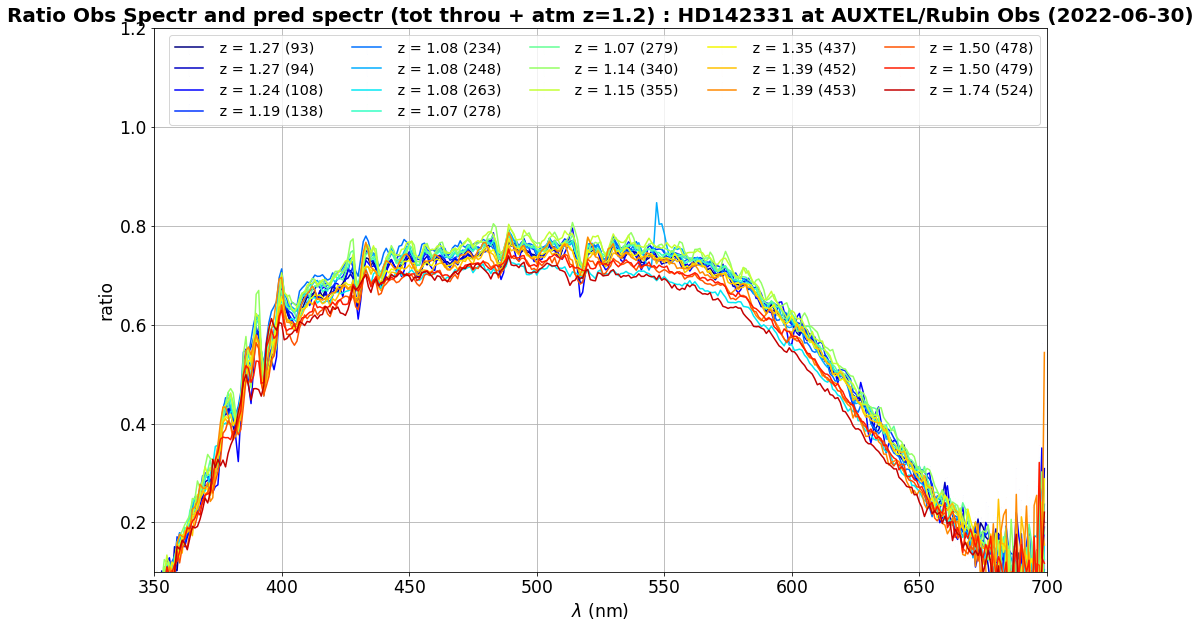

In [84]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=the_df=all_spectra[ifile]

    airmassvalue = infos.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.2f}"
    num = infos.iloc[ifile]["number"]
    label_airmass = f" z = {airmassvalue:.2f} ({num})"
    
    
    x=the_df["all_lambdas"]
    y=the_df['all_fluxes']/correction_area, 
    yerr=the_df["all_fluxes_err"]
    
    
    f = interpolate.interp1d(x, y)
    fe = interpolate.interp1d(x, yerr)
    y_interp =f(WL)[0]
    ey_interp = fe(WL)[0]
    
    
    ratio = y_interp/sed_predicted_f_filtered
    eratio = ey_interp/sed_predicted_f_filtered
    

    #if num == 87 or num == 330 or num == 331:
    ax.errorbar(WL,ratio,yerr=eratio, fmt = '-', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)

ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("ratio")
title=f"Ratio Obs Spectr and pred spectr (tot throu + atm z=1.2) : {target} at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
#ax.plot(sed_w,sed_m,'k-',label = 'SED')
#ax.plot(WL,sed_predicted_m,color='darkviolet',lw=4,label = "predicted Flux")

#ax.set_ylim(MAGLIMMIN,MAGLIMMAX)
ax.set_xlim(WLMINSEL  , WLMAXSEL  )

#ax.invert_yaxis()
ax.set_ylim(0.1,1.2)
ax.legend(loc="upper right",ncol=5)

# Make Simulation with true airmass & pressure

In [85]:
infos

,number,object,dateobs,refhour,airmass,pressure,temperature,humidity,filename,targetx_pix,targety_pix,rotangle,d2ccd
0,93,HD142331,2022-06-30T23:48:51.476,0.183745,1.268826,740.35,7.0,22.0,exposure_2022063000093_postisrccd_spectrum.fits,318.048416,1745.888769,0.247641,179.729947
1,94,HD142331,2022-06-30T23:49:34.392,0.195666,1.266461,740.35,7.0,22.0,exposure_2022063000094_postisrccd_spectrum.fits,319.263395,1745.877037,0.247028,179.781641
2,108,HD142331,2022-06-30T23:58:45.091,0.348638,1.237857,740.30,6.7,22.0,exposure_2022063000108_postisrccd_spectrum.fits,306.820786,1746.724749,0.252121,179.990008
3,138,HD142331,2022-07-01T00:18:32.201,0.678391,1.186018,740.35,6.4,23.0,exposure_2022063000138_postisrccd_spectrum.fits,310.382069,1747.307966,0.252611,179.752889
4,234,HD142331,2022-07-01T01:31:42.373,1.897883,1.083964,740.15,5.2,29.0,exposure_2022063000234_postisrccd_spectrum.fits,315.838229,1741.335465,0.252831,180.352310
5,248,HD142331,2022-07-01T01:40:58.304,2.052309,1.079273,740.15,5.1,26.0,exposure_2022063000248_postisrccd_spectrum.fits,302.611272,1744.442203,0.261100,180.403682
6,263,HD142331,2022-07-01T01:50:57.537,2.218762,1.076058,740.05,5.1,27.0,exposure_2022063000263_postisrccd_spectrum.fits,304.823184,1748.929403,0.249730,180.327468
7,278,HD142331,2022-07-01T02:00:55.370,2.384827,1.074731,740.05,4.9,26.0,exposure_2022063000278_postisrccd_spectrum.fits,308.954111,1740.641148,0.260255,180.244441
8,279,HD142331,2022-07-01T02:01:38.277,2.396746,1.074705,740.05,4.9,26.0,exposure_2022063000279_postisrccd_spectrum.fits,308.846027,1739.605508,0.256467,180.040314
9,340,HD142331,2022-07-01T03:21:52.861,3.734130,1.135884,740.25,4.7,21.0,exposure_2022063000340_postisrccd_spectrum.fits,302.886211,1737.996031,0.256878,179.553866


### Define version

In [86]:
#ATM_VERSION = "v01"
#ATM_VERSION = "v02"
ATM_VERSION = "v01"

### Define PWV

- v01 : coarse resolution
- v02 : fine resolution in 3-6 mm range

In [87]:
if ATM_VERSION == "v01":
    all_pwv = np.arange(0.,1.,5)
elif ATM_VERSION == "v02":
    all_pwv = np.arange(3.,6.,0.1)
else:
    all_pwv = np.arange(2.,6.,0.1)
NPWV = len(all_pwv)


NPWV = len(all_pwv)

### Header

- 0 : index of simulation
- 1 : index of spectra
- 2 : spectrum number
- 3 : airmass value
- 4 : pressure
- 5 : pwv
- 6 : aer
- 7 : ozone
- 8 : cloud extinction
- 9 : humidity
- 10 : start of sim

In [88]:
IDX_SIM_IDX = 0
IDX_SPEC_IDX = 1
IDX_SPEC_NUM = 2
IDX_SPEC_AM = 3
IDX_WEATH_PRES = 4
IDX_WEATH_PWV = 5
IDX_WEATH_AER = 6
IDX_WEATH_OZON = 7
IDX_WEATH_CLD = 8
IDX_WEATH_HUM = 9
IDX_SIM_START = 10

In [89]:
atmosphere_type="us"

In [90]:
#atmsimfilename = f"atmsim-{DATE}-{filterdisperser}-{atmosphere_type}-{ATM_VERSION}.npy"
atmsimfilename = f"atmsim-{DATE}-{filterdisperser}-{atmosphere_type}-{target}-{spectractormode}-{ATM_VERSION}.npy"
atmsimfilename 

'atmsim-2022-06-30-BG40~holo4_003-us-HD142331-psf2dffm-v01.npy'

In [91]:
FLAG_ATMSIMFILE = False
if os.path.isfile(atmsimfilename):
    FLAG_ATMSIMFILE = True    

In [92]:
if not FLAG_ATMSIMFILE:
    atmsim = np.zeros((NBSPECTRA*NPWV+1,IDX_SIM_START + NBINSIM))
    atmsim[0, IDX_SIM_START:] = wlsim
    
    
    # loop on spectra

    idx_sim = 0

    for idx_spec in range(NBSPECTRA):
    
        print(f"atmospheric simulation for spectrum index : {idx_spec}")
    
        num = infos.iloc[idx_spec]["number"]
        # loop on pwv
        for pwv in all_pwv:
            am       = infos.iloc[idx_spec]["airmass"]
            pressure = infos.iloc[idx_spec]["pressure"]
            hum      = infos.iloc[idx_spec]["humidity"]
            aer      = 0
            ozone    = 300.
            cloudext = 0
    
    
            path,thefile=libsimulateVisible.ProcessSimulation(am,pwv,ozone,pressure,prof_str='us',proc_str='sa',cloudext=cloudext)
            data = np.loadtxt(os.path.join(path,thefile))
            wlsim = data[:,0]
            tratmsim = data[:,1]
        
        
            # counter on simulation from 1 to NBSPECTRA*NPWV
            idx_sim += 1
        
            ## fill array
            atmsim[idx_sim,IDX_SIM_IDX]    = idx_sim
            atmsim[idx_sim,IDX_SPEC_IDX]   = idx_spec
            atmsim[idx_sim,IDX_SPEC_NUM]   = num 
            atmsim[idx_sim,IDX_SPEC_AM]    = am
            atmsim[idx_sim,IDX_WEATH_PRES] = pressure
            atmsim[idx_sim,IDX_WEATH_PWV]  = pwv
            atmsim[idx_sim,IDX_WEATH_AER]  = aer
            atmsim[idx_sim,IDX_WEATH_OZON] = ozone
            atmsim[idx_sim,IDX_WEATH_CLD]  = cloudext
            atmsim[idx_sim,IDX_WEATH_HUM]  = hum
            atmsim[idx_sim,IDX_SIM_START:] = tratmsim
            
else:
    print(f"Load file {atmsimfilename}")
    atmsim = np.load(atmsimfilename)
    print(atmsim.shape)
        
        
    

Load file atmsim-2022-06-30-BG40~holo4_003-us-HD142331-psf2dffm-v01.npy
(18, 961)


In [93]:
if not FLAG_ATMSIMFILE:
    np.save(atmsimfilename,atmsim)
    FLAG_ATMSIMFILE = True

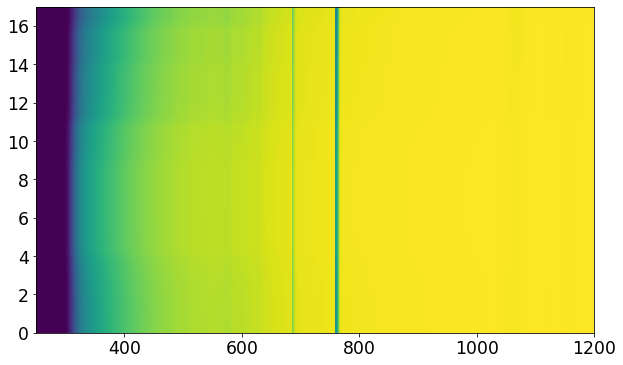

In [94]:
plt.imshow(atmsim[1:,IDX_SIM_START:],origin="lower", aspect='auto', extent = [ atmsim[0,IDX_SIM_START],atmsim[0,-1],0,NBSPECTRA*NPWV ])

# Compute ratio

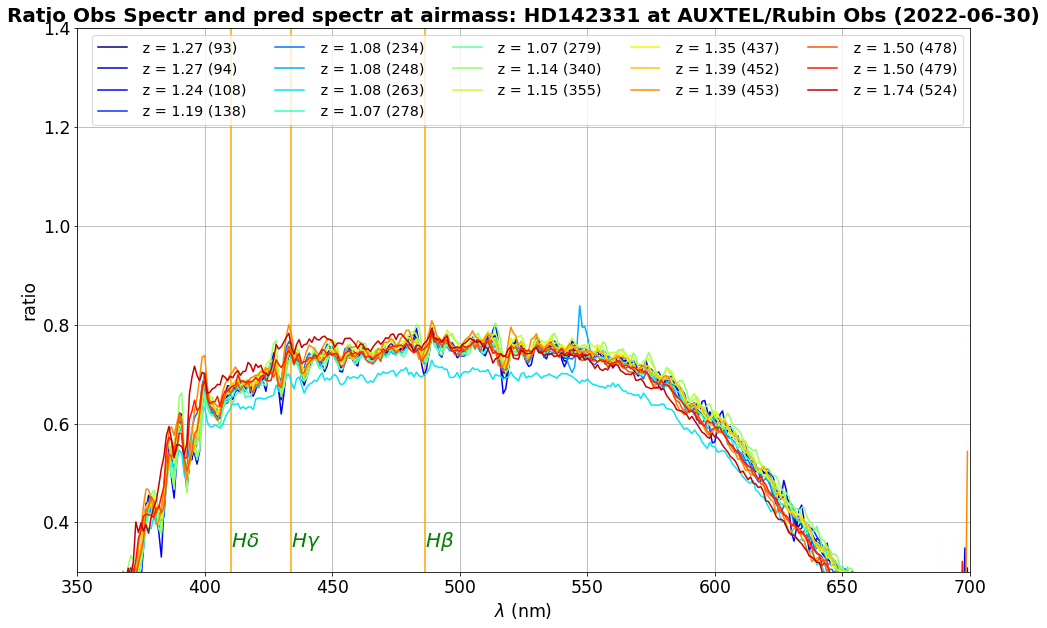

In [95]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
all_ratio = []
all_spectra_interp = []

for ifile in np.arange(NBSPECTRA):
    the_df=the_df=all_spectra[ifile]

    airmassvalue = infos.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.2f}"
    num = infos.iloc[ifile]["number"]
    label_airmass = f" z = {airmassvalue:.2f} ({num})"
    
    
    # data
    x=the_df["all_lambdas"]
    y=the_df['all_fluxes']/correction_area
    yerr=the_df["all_fluxes_err"]/correction_area
    
    
    f = interpolate.interp1d(x, y)
    fe = interpolate.interp1d(x, yerr)
    y_interp =f(WL)
    ey_interp = fe(WL)
    
    # atmsim
    x0 = atmsim[0, IDX_SIM_START:]
    #y0 = atmsim[ifile*NPWV+1 + 2  ,IDX_SIM_START:]
    y0 = atmsim[ifile*NPWV+1 + 0  ,IDX_SIM_START:] # pas pwd
    f0_atm = interpolate.interp1d(x0,y0,bounds_error=False,fill_value="extrapolate")
    flux_predicted_f = f_sed(WL) * f_thr(WL) * f0_atm(WL) * f_filter_thr(WL)
    span = 3
    flux_predicted_f_filtered = smooth_data_np_convolve(flux_predicted_f, span)
    
    
    ratio = y_interp/flux_predicted_f_filtered
    eratio = ey_interp/flux_predicted_f_filtered
    
    all_ratio.append(ratio)
    all_spectra_interp.append(y_interp)
    

    #if num == 87 or num == 330 or num == 331:
    ax.errorbar(WL,ratio,yerr=eratio, fmt = '-', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)

ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("ratio")
title=f"Ratio Obs Spectr and pred spectr at airmass: {target} at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
#ax.plot(sed_w,sed_m,'k-',label = 'SED')
#ax.plot(WL,sed_predicted_m,color='darkviolet',lw=4,label = "predicted Flux")

#ax.set_ylim(MAGLIMMIN,MAGLIMMAX)
ax.set_xlim(WLMINSEL  , WLMAXSEL  )

#ax.invert_yaxis()
ax.set_ylim(0.3,1.4)
ax.legend(loc="upper right",ncol=5)

plotlines(ax,ypos=0.35)

rect=mpl.patches.Rectangle((780,0.3),115,1.4,color ='yellow',alpha=0.3)
ax.add_patch(rect)

# Find the upper curve for the ratio and calculate ratio of ratio to get grey attenuation

In [96]:
indexes=np.where(np.logical_and(WL> 440,WL<525))[0]  

In [97]:
average_ratio = np.array([ np.mean(ratio[indexes]) for ratio in  all_ratio])

In [98]:
idx_max = np.where(average_ratio == average_ratio.max())[0][0]
ratio_max= all_ratio[idx_max]

airmassvalue = infos.iloc[idx_max]["airmass"]
num = infos.iloc[idx_max]["number"]
label_airmass = f" z = {airmassvalue:.2f} ({num})"

label_ratio_max = label_airmass

In [99]:
idx_min = np.where(average_ratio == average_ratio.min())[0][0]
ratio_min= all_ratio[idx_min]

airmassvalue = infos.iloc[idx_min]["airmass"]
num = infos.iloc[idx_min]["number"]
label_airmass = f" z = {airmassvalue:.2f} ({num})"

label_ratio_min = label_airmass

In [100]:
idx_zmin = np.where(infos["airmass"].values == infos["airmass"].values.min())[0][0]
ratio_zmin= all_ratio[idx_zmin]

airmassvalue = infos.iloc[idx_zmin]["airmass"]
num = infos.iloc[idx_zmin]["number"]
label_airmass = f" z = {airmassvalue:.2f} ({num})"

label_ratio_zmin = label_airmass

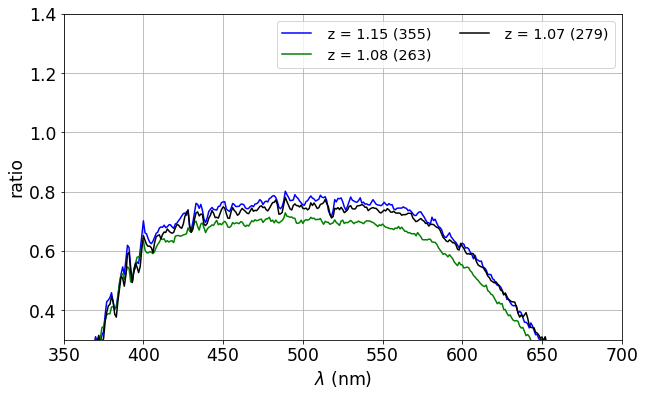

In [101]:
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)
ax.plot(WL,ratio_max,'b-',label=label_ratio_max)
ax.plot(WL,ratio_min,'g-',label=label_ratio_min)
ax.plot(WL,all_ratio[idx_zmin],'k-',label=label_ratio_zmin)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("ratio")
ax.set_xlim( WLMINSEL  , WLMAXSEL  )

#ax.invert_yaxis()
ax.set_ylim(0.3,1.4)
ax.legend(loc="upper right",ncol=2)

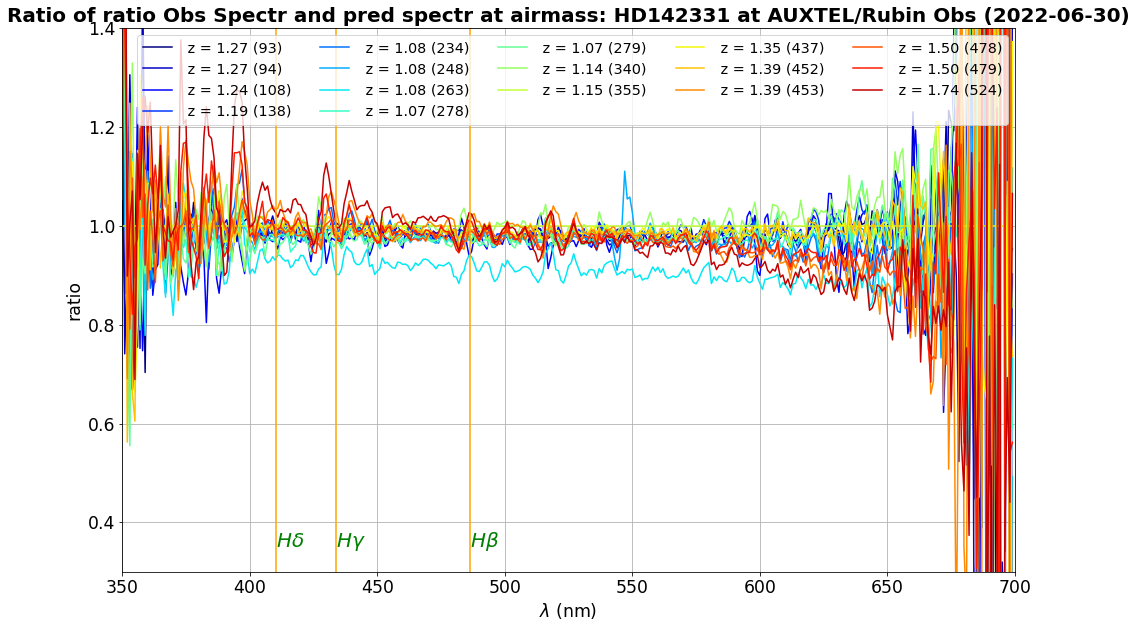

In [102]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)

all_ratioofratio = []

for ifile in np.arange(NBSPECTRA):
 
    airmassvalue = infos.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.2f}"
    num = infos.iloc[ifile]["number"]
    label_airmass = f" z = {airmassvalue:.2f} ({num})"
    
     
    ratio = all_ratio[ifile]/ratio_max
    all_ratioofratio.append(ratio)
      
    ax.plot(WL,ratio, '-', color=all_colors[ifile],label=label_airmass)

  
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("ratio")
title=f"Ratio of ratio Obs Spectr and pred spectr at airmass: {target} at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
#ax.plot(sed_w,sed_m,'k-',label = 'SED')
#ax.plot(WL,sed_predicted_m,color='darkviolet',lw=4,label = "predicted Flux")

#ax.set_ylim(MAGLIMMIN,MAGLIMMAX)
ax.set_xlim( WLMINSEL  , WLMAXSEL  )

#ax.invert_yaxis()
ax.set_ylim(0.3,1.4)
ax.legend(loc="upper right",ncol=5)

plotlines(ax,ypos=0.35)

In [103]:
grey_attenuation =  np.array([ np.mean(ratio[indexes]) for ratio in  all_ratioofratio])

In [104]:
grey_attenuation

array([0.98049242, 0.98160124, 0.97506508, 0.9867018 , 0.98244292,
       0.97282767, 0.9175384 , 0.97228081, 0.97330203, 0.99280635,
       1.        , 0.98859268, 0.98511052, 0.99777371, 0.97609854,
       0.98362621, 0.999863  ])

Text(0.5, 0, 'grey attenuation')

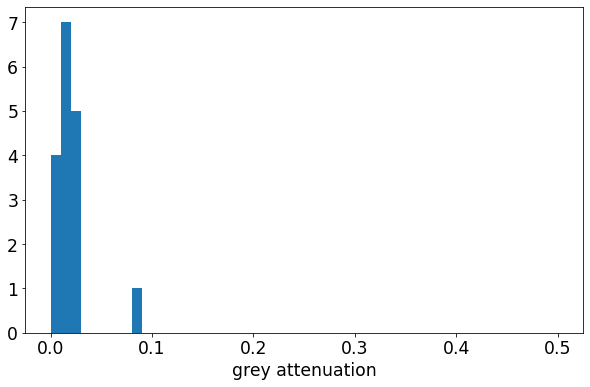

In [105]:
plt.hist(1-grey_attenuation,bins=50,range=(0,0.5));
plt.xlabel("grey attenuation")

In [106]:
filterdisperser

'BG40~holo4_003'

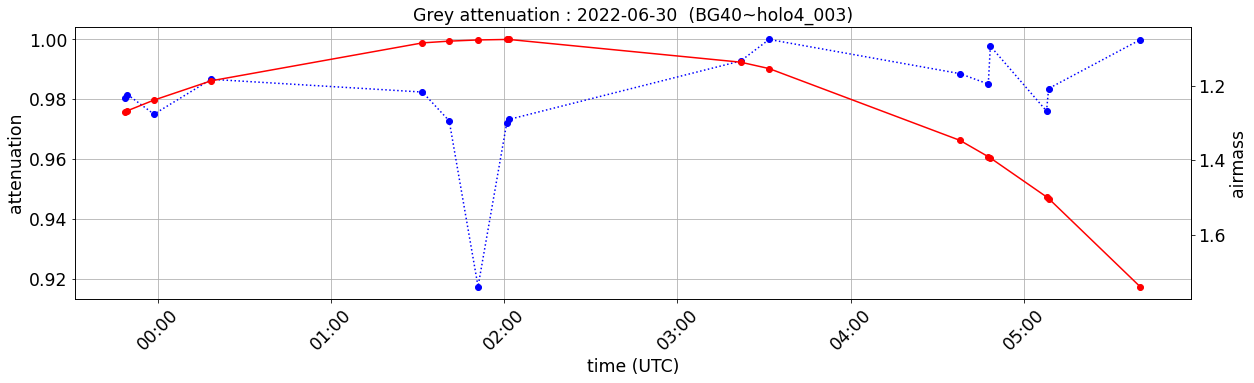

In [107]:
all_datetime = [ Time(str_time).to_datetime() for str_time in infos['dateobs'] ]
myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)

fig=plt.figure(figsize=(20,5))
ax=fig.add_subplot(111)
ax.plot(all_datetime,grey_attenuation,'bo:')
ax.grid()
#plt.gcf().autofmt_xdate()
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_tick_params(rotation=45)
ax.set_xlabel("time (UTC)")
ax.set_title(f"Grey attenuation : {DATE}  ({filterdisperser})")
ax.set_ylabel("attenuation")
ax2 = ax.twinx() 
ax2.plot(all_datetime,infos["airmass"].values,'o-r')
ax2.xaxis.set_major_formatter(myFmt)
ax2.xaxis.set_tick_params(rotation=45)
ax2.set_xlabel("time (UTC)")
ax2.set_ylabel("airmass")
ax2.invert_yaxis()

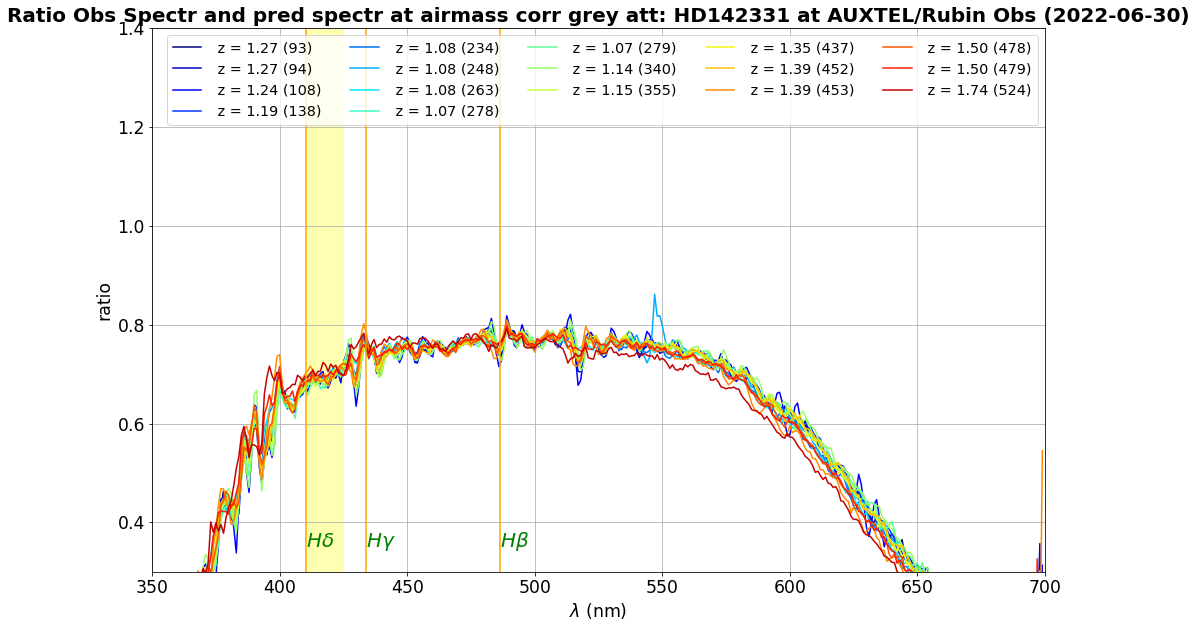

In [108]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)

all_ratio_nogreyatt = []
all_airmass = []


for ifile in np.arange(NBSPECTRA):
    
    airmassvalue = infos.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.2f}"
    num = infos.iloc[ifile]["number"]
    label_airmass = f" z = {airmassvalue:.2f} ({num})"
    all_airmass.append(airmassvalue)
    
    ratio = all_ratio[ifile]/grey_attenuation[ifile]
    
    

    #if num == 87 or num == 330 or num == 331:
    ax.plot(WL,ratio,'-', color=all_colors[ifile],label=label_airmass)

    all_ratio_nogreyatt.append(ratio)
    
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("ratio")
title=f"Ratio Obs Spectr and pred spectr at airmass corr grey att: {target} at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
#ax.plot(sed_w,sed_m,'k-',label = 'SED')
#ax.plot(WL,sed_predicted_m,color='darkviolet',lw=4,label = "predicted Flux")

#ax.set_ylim(MAGLIMMIN,MAGLIMMAX)
ax.set_xlim( WLMINSEL  , WLMAXSEL  )

#ax.invert_yaxis()
ax.set_ylim(0.3,1.4)
ax.legend(loc="upper right",ncol=5)

rect=mpl.patches.Rectangle((410,0.3),15,1.4,color ='yellow',alpha=0.3)
ax.add_patch(rect)

plotlines(ax,ypos=0.35)

# Data / Simulation

# Pair of Exposures

In [109]:
dfpair = FindPairOfExposures(infos)
dfpair

/var/folders/m7/6pm3rhtj0c71ls7jj9mn1g740000gp/T/ipykernel_80106/3557910445.py:32: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist = np.abs(df1["airmass"][np.newaxis, :] - df2["airmass"][:, np.newaxis])


,idx1,idx2,num1,num2,z1,z2,zdiff,dtime
0,0,11,93,437,1.268826,1.346323,0.077497,4.816347
1,1,11,94,437,1.266461,1.346323,0.079862,4.804426
2,2,10,108,355,1.237857,1.153110,-0.084746,3.549907
3,3,10,138,355,1.186018,1.153110,-0.032907,3.220154
4,4,9,234,340,1.083964,1.135884,0.051920,1.836247
5,5,9,248,340,1.079273,1.135884,0.056611,1.681821
6,6,9,263,340,1.076058,1.135884,0.059826,1.515368
7,7,9,278,340,1.074731,1.135884,0.061153,1.349303


In [110]:
rank=0
idx1_pair = int(dfpair.iloc[rank]["idx1"])
idx2_pair = int(dfpair.iloc[rank]["idx2"])
spec_pair_1  = all_spectra_interp[idx1_pair]
spec_pair_2  = all_spectra_interp[idx2_pair]
num1 = int(dfpair.iloc[rank]["num1"])
num2 = int(dfpair.iloc[rank]["num2"])
z1 = dfpair.iloc[rank]["z1"]
z2 = dfpair.iloc[rank]["z2"]
dt = dfpair.iloc[rank]["dtime"]
dz = dfpair.iloc[rank]["zdiff"]

In [111]:
ratio_spectra=spec_pair_2/spec_pair_1
span=15
ratio_spectra_smoo = smooth_data_np_convolve(ratio_spectra, span)
label = f"flux ratio : (#{num2}, z2={z2:.2f})/(#{num1}, z1={z1:.2f}), dt={dt:.1f} hours"

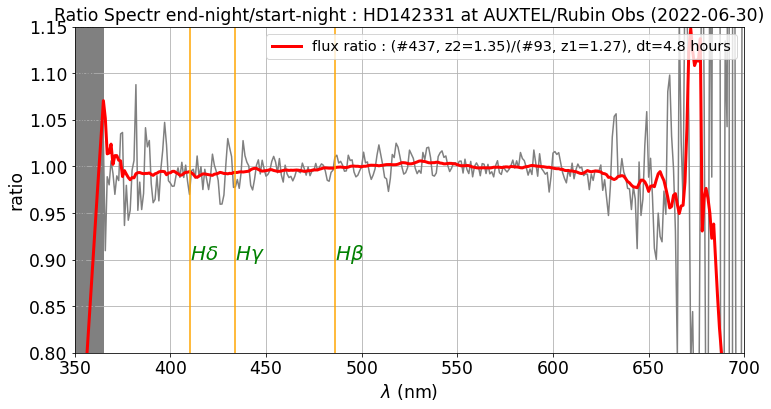

In [112]:
fig=plt.figure(figsize=(12,6))
ax=fig.add_subplot(111)


ax.plot(WL,ratio_spectra,"-",color="grey")

ax.plot(WL,ratio_spectra_smoo,"r-",lw=3,label=label) 
ax.grid()
ymin=0.8
ymax=1.15
ax.set_ylim(ymin,ymax)
ax.set_xlim(WLMINSEL,WLMAXSEL)

ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("ratio")
title=f"Ratio Spectr end-night/start-night : {target} at {SITE} ({DATE})"
ax.set_title(title)
ax.legend(loc='upper right')

rect=mpl.patches.Rectangle((WLMINSEL,ymin),span,ymax,color ='grey',alpha=1)
ax.add_patch(rect)


# draw abs lines
plotlines(ax,ypos=0.9)

# Pair of exposures

In [113]:
dfpair = FindPairOfExposures(infos)
dfpair

/var/folders/m7/6pm3rhtj0c71ls7jj9mn1g740000gp/T/ipykernel_80106/3557910445.py:32: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dist = np.abs(df1["airmass"][np.newaxis, :] - df2["airmass"][:, np.newaxis])


,idx1,idx2,num1,num2,z1,z2,zdiff,dtime
0,0,11,93,437,1.268826,1.346323,0.077497,4.816347
1,1,11,94,437,1.266461,1.346323,0.079862,4.804426
2,2,10,108,355,1.237857,1.153110,-0.084746,3.549907
3,3,10,138,355,1.186018,1.153110,-0.032907,3.220154
4,4,9,234,340,1.083964,1.135884,0.051920,1.836247
5,5,9,248,340,1.079273,1.135884,0.056611,1.681821
6,6,9,263,340,1.076058,1.135884,0.059826,1.515368
7,7,9,278,340,1.074731,1.135884,0.061153,1.349303


In [114]:
rank=1
idx1_pair = int(dfpair.iloc[rank]["idx1"])
idx2_pair = int(dfpair.iloc[rank]["idx2"])
spec_pair_1  = all_spectra_interp[idx1_pair]/average_ratio[idx1_pair]
spec_pair_2  = all_spectra_interp[idx2_pair]/average_ratio[idx2_pair]

#specsim_pair_1 = all_spectra_sim_interp[idx1_pair]
#specsim_pair_2 = all_spectra_sim_interp[idx2_pair]

z1 = dfpair.iloc[rank]["z1"]
z2 = dfpair.iloc[rank]["z2"]
dt = dfpair.iloc[rank]["dtime"]
dz = dfpair.iloc[rank]["zdiff"]
num1 = int(dfpair.iloc[rank]["num1"])
num2 = int(dfpair.iloc[rank]["num2"])

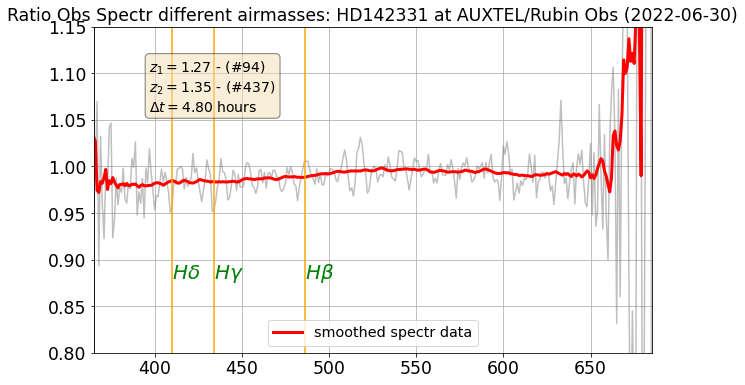

In [115]:
ratio_spectra=spec_pair_2/spec_pair_1
#ratio_spectrasim=specsim_pair_2/specsim_pair_1
span=15
ratio_spectra_smoo = smooth_data_np_convolve(ratio_spectra, span)
#ratio_spectrasim_smoo = smooth_data_np_convolve(ratio_spectrasim, span)

ax=None
fig=plt.figure(figsize=(10,6))
plt.plot(WL,ratio_spectra,color="grey",alpha=0.5)

plt.plot(WL,ratio_spectra_smoo,"r-",lw=3,label="smoothed spectr data") 
#plt.plot(WL,ratio_spectrasim_smoo,"b-",lw=3,label="smoothed spec sim") 
plt.grid()
plt.legend(loc="lower center")
ymin=0.8
ymax=1.15
plt.ylim(ymin,ymax)
plt.xlim(WLMINSEL+span,WLMAXSEL-span)
#title = f"z1={z1:.2f}, z2={z2:.2f}, dt={dt:.1f}"
title=f"Ratio Obs Spectr different airmasses: {target} at {SITE} ({DATE})"

plt.title(title)

textstr = '\n'.join((
    r'$z_1=%.2f$ - (#%.d)' % (z1,num1 ),
    r'$z_2=%.2f$ - (#%.d)' % (z2,num2 ),
    r'$\Delta t=%.2f$ hours' % (dt, )))

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
if not ax:
    ax = plt.gca()
ax.text(0.1, 0.9, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plotlines(ax,ypos=0.88)

rect=mpl.patches.Rectangle((WLMINSEL,ymin),span,ymax,color ='grey',alpha=1)
ax.add_patch(rect)



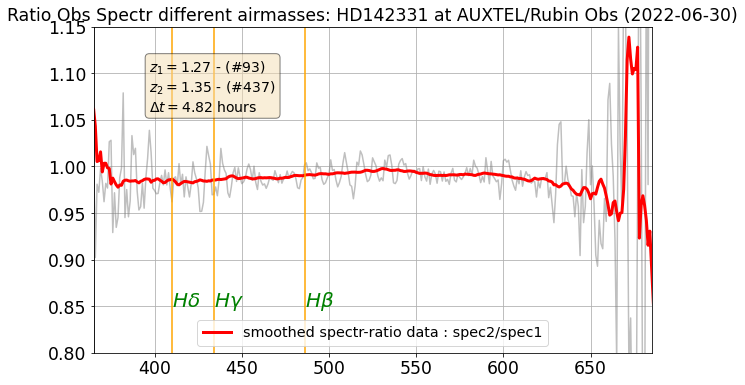

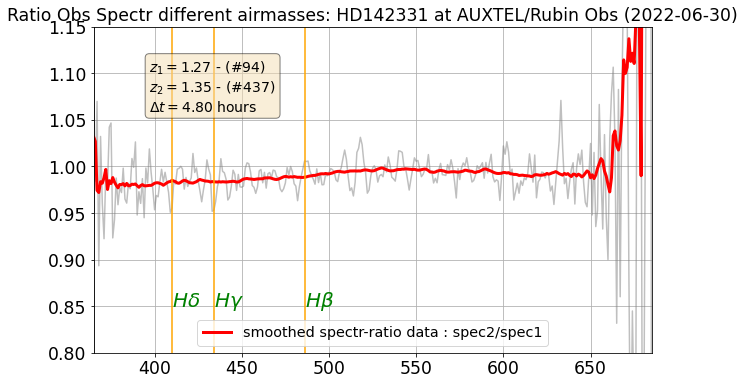

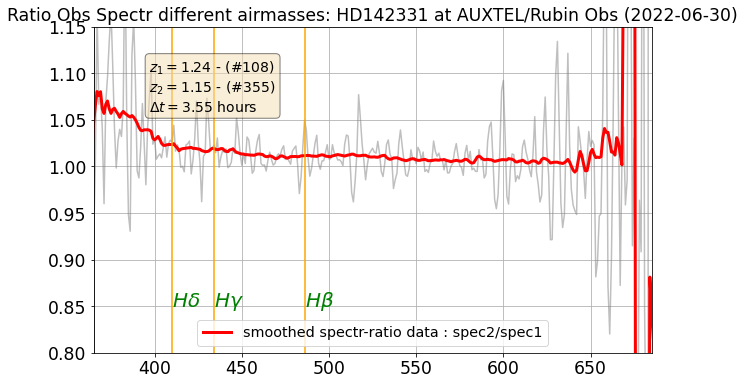

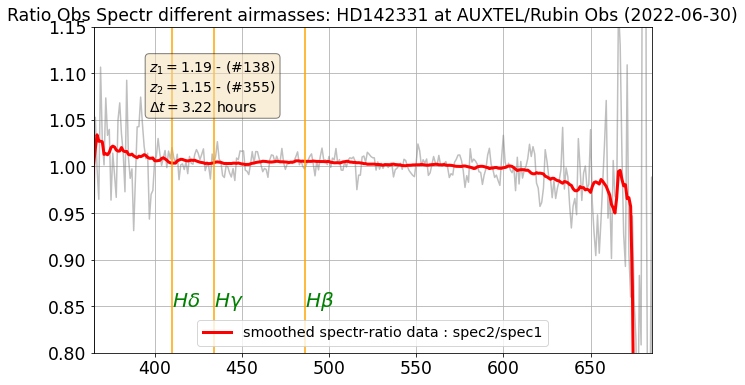

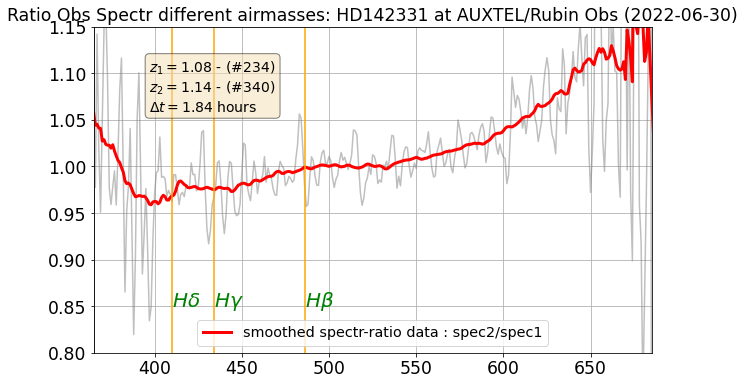

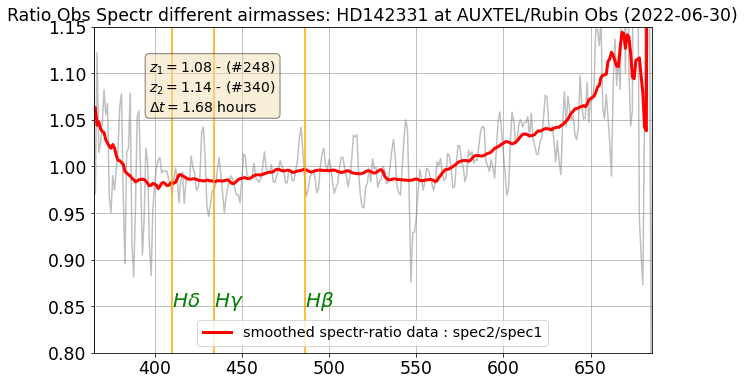

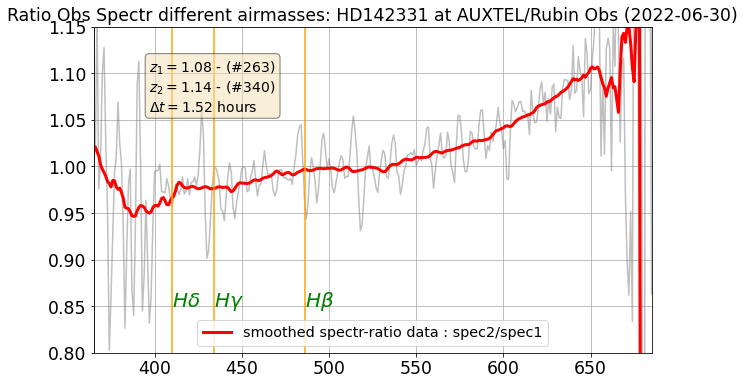

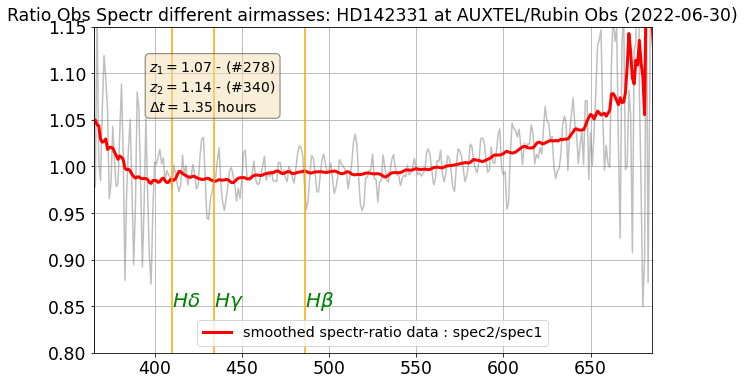

In [116]:
for irank in range(len(dfpair)):
    fig=plt.figure(figsize=(10,6))
    ax=fig.add_subplot(111)
    
    idx1_pair = int(dfpair.iloc[irank]["idx1"])
    idx2_pair = int(dfpair.iloc[irank]["idx2"])
    spec_pair_1  = all_spectra_interp[idx1_pair]/average_ratio[idx1_pair]
    spec_pair_2  = all_spectra_interp[idx2_pair]/average_ratio[idx2_pair]
    #specsim_pair_1 = all_spectra_sim_interp[idx1_pair]
    #specsim_pair_2 = all_spectra_sim_interp[idx2_pair]
    z1 = dfpair.iloc[irank]["z1"]
    z2 = dfpair.iloc[irank]["z2"]
    dt = dfpair.iloc[irank]["dtime"]
    num1 = int(dfpair.iloc[irank]["num1"])
    num2 = int(dfpair.iloc[irank]["num2"])
    
    ratio_spectra=spec_pair_2/spec_pair_1
    #ratio_spectrasim=specsim_pair_2/specsim_pair_1
    span=15
    ratio_spectra_smoo = smooth_data_np_convolve(ratio_spectra, span)
    #ratio_spectrasim_smoo = smooth_data_np_convolve(ratio_spectrasim, span)
    ax.plot(WL,ratio_spectra,color="grey",alpha=0.5)
    ax.plot(WL,ratio_spectra_smoo,"r-",lw=3,label="smoothed spectr-ratio data : spec2/spec1") 
    #ax.plot(WL,ratio_spectrasim_smoo,"b-",lw=3,label="smoothed spectr-ratio sim (no aerosol)") 
    ax.grid()
    ax.legend(loc='lower center')
    ymin=0.8
    ymax=1.15
    ax.set_ylim(ymin,ymax)
    ax.set_xlim(WLMINSEL+span,WLMAXSEL-span)
    title = f"z1={z1:.2f}, z2={z2:.2f}, dt={dt:.1f}"
    title=f"Ratio Obs Spectr different airmasses: {target} at {SITE} ({DATE})"
    
    textstr = '\n'.join((
    r'$z_1=%.2f$ - (#%.d)' % (z1,num1 ),
    r'$z_2=%.2f$ - (#%.d)' % (z2,num2 ),
    r'$\Delta t=%.2f$ hours' % (dt, )))
    
    ax.set_title(title)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.1, 0.9, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    
    plotlines(ax,ypos=0.85)
    
    rect=mpl.patches.Rectangle((WLMINSEL,ymin),span,ymax,color ='grey',alpha=1)
    ax.add_patch(rect)

   
    plt.show()
    
    